This is the fourth tutorial and explains the basic usage of DoG-HiT by recovering the ring synthetic image from ngEHT coverage. This tutorial is meant to present some of the fundamental ideas behind DoG-HiT. Note that the complete analysis pipeline with the best reconstruction results will be shown in tutorial 6.

The minimization by wavelets with DoG-HiT is handled by the MinimizationHandler class. Let us load all the needed modules.

In [1]:
#-------------------------------------------------------------------------------
# Modules
#-------------------------------------------------------------------------------
import ehtim as eh
import numpy as np

import logging

from imagingbase.minimization_handler import MinimizationHandler

import ehtplot.color
cfun = 'afmhot_u'

import pathlib 
current_path = str(pathlib.Path().absolute())

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(name)-20s :: %(message)s'
)

Welcome to eht-imaging! v 1.2.6 



Fixed imaging parameters

In [2]:
#-------------------------------------------------------------------------------
# Fixed imaging parameters
#-------------------------------------------------------------------------------
ttype     = 'direct'            # Type of Fourier transform ('direct', 'nfft', or 'fast')

zbl       = 0.6                 # Total compact flux density (Jy)
npix      = 64                 # Number of pixels across the reconstructed image
fov       = 256*eh.RADPERUAS    # Field of view of the reconstructed image

#data weights
data_term = {'amp'    : 0.2,    # visibility amplitudes
             'cphase' : 1.0,    # closure phases
             'logcamp': 1.0}    # log closure amplitudes

prior_fwhm = 40.0*eh.RADPERUAS  # Gaussian prior FWHM (radians)
rescaling = 0.001              # rescale intensities per pixel to obtain values of the order ~1

cbar_lims = [0, 1*10**10]       #cbar-lims for interactive plotting (brightness temperature)

Loading uvfits:  /homes/hmueller/mrbeam/mr_beam/examples/../synthetic_data/ring_ngeht_averaged.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!
Loading fits image:  /homes/hmueller/mrbeam/mr_beam/examples/../synthetic_data/ring.fits


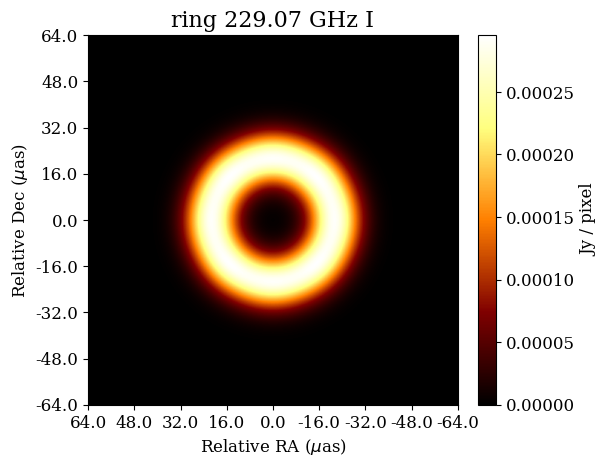

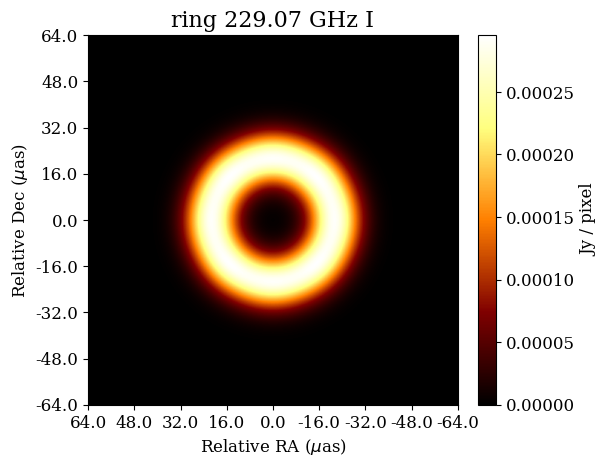

In [3]:
#Load observations
obs_sc = eh.obsdata.load_uvfits(current_path+r'/../synthetic_data/ring_ngeht_averaged.uvfits')
exact_solution = eh.image.load_fits(current_path+r'/../synthetic_data/ring.fits')

exact_solution.display()

In [4]:
#Define prior image as an initial guess
prior = eh.image.make_square(obs_sc, npix, fov) #prior image, make a prior image
prior = prior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0, 0, 0))

Up to now we followed very close the procedure that we know from tutorial 2. Now we have to define the data fidelity terms and the penalty term. For DoG-HiT we model the image by a dictionary of wavelet functions, use closure quantities as data terms and an l0 penalization on the wavelet coefficients. Moreover, we utilize a total flux constraint. These terms do not have to be allocated manually, this is done by the MinimizationHandler class. As the ngEHT array is very dense, we do not fit the widths of the wavelet functions, but specify them manually for now. Now we can allocate the MinimizationHandler class.

In [5]:
#------------------------------------------------------------------------------
# Prepare Minimization Procedure
#------------------------------------------------------------------------------
#clean beam fwhm
psf_fwhm = 20*eh.RADPERUAS

#threshold for identifying gaps in uv-coverage
threshold = 0.01*10**9
#specify widths of wavelezs manually
widths = np.array([1, 2, 4, 6, 8, 12, 16])
#the final handler for the minimization procedure
handler = MinimizationHandler(psf_fwhm, npix, fov, obs_sc, prior, zbl, rescaling, data_term, cbar_lims, threshold, [], [], widths=widths) 
#widths of wavelet filters
widths = handler.widths

Generating I image...
Generating I image...
Generating I image...
Generating I image...


Now we define a proper initial guess. We use the prior image as an initial guess. Note that we expect an odd number of pixels in case of a small number of pixels to represent wavelets centrally symmetric. Due to the completeness property of wavelets (all the wavelet functions sum to a delta function) it is a reasonable wavelet representation of the prior image to copy the prior image into all scales, in particular for nearly orthogonal wavelets. The data are rescaled to have values in the range ~1 for numerical performance reasons.

In [13]:
img = prior.regrid_image(fov, npix+1)

#Find initial guess by expressing img by dictionary
#Decomposition computed by Landweber inversion
data = handler.convert.ehtim_to_numpy(img)/rescaling

init = np.zeros((len(widths), npix+1, npix+1))
for j in range(len(widths)):
    init[j] = data
init = init.flatten()

The next step is to run the minimization. For DoG-HiT we proposed to use a forward-backward splitting scheme with iterative rescaling to a fixed total flux. This procedure is implemented in regpy and can be called by handler.second_round. The regularization parameter alpha controls the bias between the data fidelity term and the penalty term. The parameter is the step-size parameter for the forward-backward splitting scheme. Furthermore, there is the opportunity to threshold some scales stronger than other scales by the noise_levels parameter. If noise_levels == ones, then the relative weights are taken optimally by the size of the wavelets.

2023-10-18 14:56:19,061 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 14:56:19,062 INFO Display              :: Penalty--> 3316.0985221679816
2023-10-18 14:56:19,305 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 14:56:19,306 INFO Display              :: Penalty--> 3315.8054905115296
2023-10-18 14:56:19,560 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 14:56:19,562 INFO Display              :: Penalty--> 3315.461514060074
2023-10-18 14:56:19,826 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 14:56:19,827 INFO Display              :: Penalty--> 3315.314806707889
2023-10-18 14:56:20,085 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 14:56:20,086 INFO Display              :: Penalty--> 3315.2025736682285
2023-10-18 14:56:20,336 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 14:56:20,337 INFO Display              :: Penalty--> 3315.0945541556534
2023-10-18 14:56:20,586 INFO CountIterations      :: iteration = 7 / 25


-28297.578079874373
Data Fidelity:  4905.482875812766


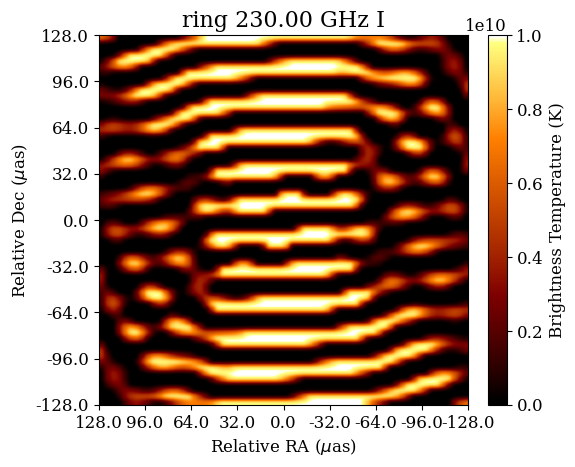

2023-10-18 14:56:25,912 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 14:56:25,914 INFO Display              :: Penalty--> 2416.1667576387267
2023-10-18 14:56:26,161 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 14:56:26,162 INFO Display              :: Penalty--> 2388.0037974961037
2023-10-18 14:56:26,437 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 14:56:26,438 INFO Display              :: Penalty--> 2381.802988604317
2023-10-18 14:56:26,709 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 14:56:26,710 INFO Display              :: Penalty--> 2378.433229287155
2023-10-18 14:56:26,956 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 14:56:26,957 INFO Display              :: Penalty--> 2371.517472463155
2023-10-18 14:56:27,203 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 14:56:27,205 INFO Display              :: Penalty--> 2366.4671019931448
2023-10-18 14:56:27,455 INFO CountIterations      :: iteration = 7 / 25
2

2880.207425970947
Data Fidelity:  1551.4658143164183


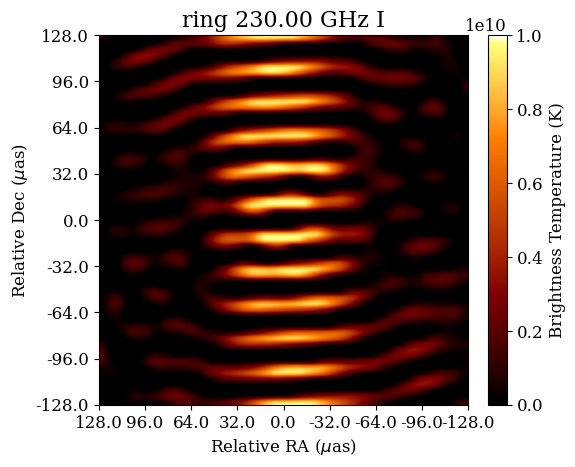

2023-10-18 14:56:32,669 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 14:56:32,670 INFO Display              :: Penalty--> 979.018574317219
2023-10-18 14:56:32,906 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 14:56:32,908 INFO Display              :: Penalty--> 954.3117304976917
2023-10-18 14:56:33,144 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 14:56:33,145 INFO Display              :: Penalty--> 939.9723733871082
2023-10-18 14:56:33,406 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 14:56:33,408 INFO Display              :: Penalty--> 927.4613103414819
2023-10-18 14:56:33,664 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 14:56:33,666 INFO Display              :: Penalty--> 920.0377670563666
2023-10-18 14:56:33,960 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 14:56:33,962 INFO Display              :: Penalty--> 911.5356166827416
2023-10-18 14:56:34,209 INFO CountIterations      :: iteration = 7 / 25
2023-

733.6924610363985
Data Fidelity:  653.7837806822977


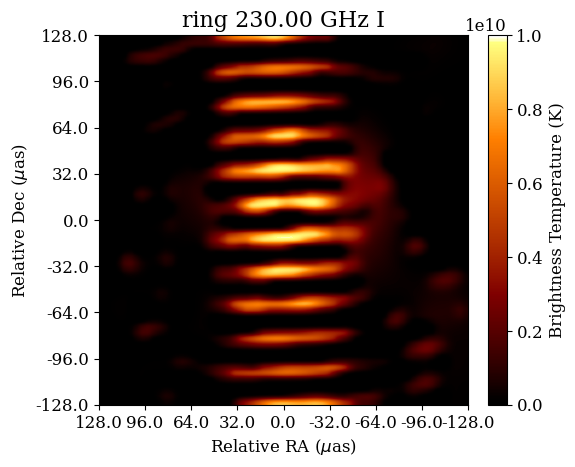

2023-10-18 14:56:39,370 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 14:56:39,372 INFO Display              :: Penalty--> 758.0746119746264
2023-10-18 14:56:39,610 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 14:56:39,611 INFO Display              :: Penalty--> 749.3322043431203
2023-10-18 14:56:39,847 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 14:56:39,849 INFO Display              :: Penalty--> 742.961850751363
2023-10-18 14:56:40,082 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 14:56:40,084 INFO Display              :: Penalty--> 737.9856483618041
2023-10-18 14:56:40,341 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 14:56:40,342 INFO Display              :: Penalty--> 734.5396653989193
2023-10-18 14:56:40,581 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 14:56:40,582 INFO Display              :: Penalty--> 732.3246500240767
2023-10-18 14:56:40,818 INFO CountIterations      :: iteration = 7 / 25
2023-

670.5521415112039
Data Fidelity:  558.253960424704


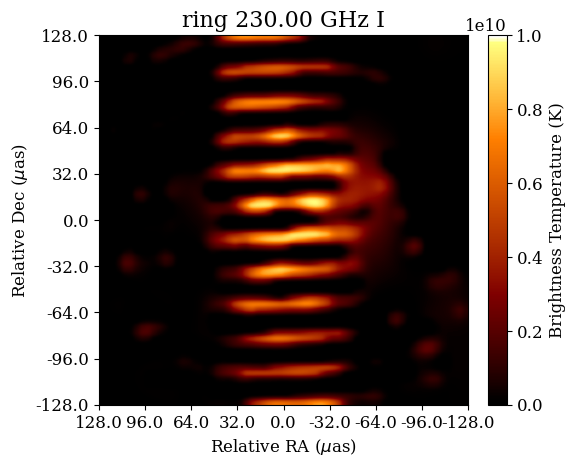

2023-10-18 14:56:45,825 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 14:56:45,827 INFO Display              :: Penalty--> 646.8719684865215
2023-10-18 14:56:46,094 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 14:56:46,096 INFO Display              :: Penalty--> 637.205699345453
2023-10-18 14:56:46,339 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 14:56:46,341 INFO Display              :: Penalty--> 632.6852319835857
2023-10-18 14:56:46,592 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 14:56:46,594 INFO Display              :: Penalty--> 628.8345134776831
2023-10-18 14:56:46,831 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 14:56:46,833 INFO Display              :: Penalty--> 626.1180872236782
2023-10-18 14:56:47,122 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 14:56:47,124 INFO Display              :: Penalty--> 625.7346574147282
2023-10-18 14:56:47,387 INFO CountIterations      :: iteration = 7 / 25
2023-

708.3847660095302
Data Fidelity:  482.004581087282


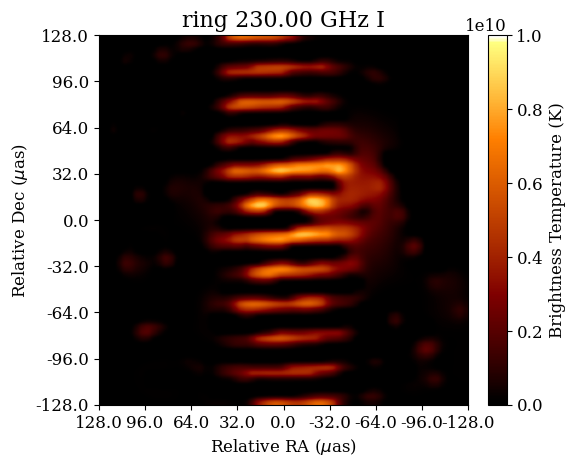

2023-10-18 14:56:52,911 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 14:56:52,913 INFO Display              :: Penalty--> 490.23150668196547
2023-10-18 14:56:53,150 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 14:56:53,151 INFO Display              :: Penalty--> 480.8129792835425
2023-10-18 14:56:53,392 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 14:56:53,393 INFO Display              :: Penalty--> 478.01419830534667
2023-10-18 14:56:53,661 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 14:56:53,663 INFO Display              :: Penalty--> 472.9758490038891
2023-10-18 14:56:53,920 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 14:56:53,922 INFO Display              :: Penalty--> 471.4493162630025
2023-10-18 14:56:54,186 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 14:56:54,187 INFO Display              :: Penalty--> 471.75083659869006
2023-10-18 14:56:54,446 INFO CountIterations      :: iteration = 7 / 25
2

687.8306366961733
Data Fidelity:  440.8166262042711


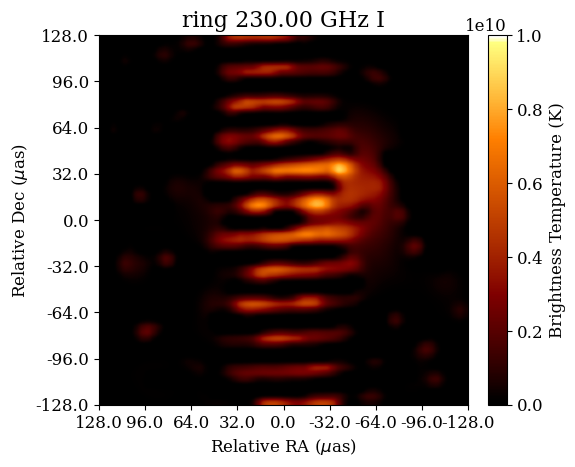

2023-10-18 14:56:59,868 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 14:56:59,870 INFO Display              :: Penalty--> 367.5985847708351
2023-10-18 14:57:00,113 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 14:57:00,114 INFO Display              :: Penalty--> 352.7865202080081
2023-10-18 14:57:00,358 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 14:57:00,360 INFO Display              :: Penalty--> 350.1764910153008
2023-10-18 14:57:00,594 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 14:57:00,595 INFO Display              :: Penalty--> 348.4950602328455
2023-10-18 14:57:00,892 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 14:57:00,893 INFO Display              :: Penalty--> 347.86700833220596
2023-10-18 14:57:01,137 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 14:57:01,138 INFO Display              :: Penalty--> 346.9972537739316
2023-10-18 14:57:01,378 INFO CountIterations      :: iteration = 7 / 25
202

694.7242962736086
Data Fidelity:  442.5597632256161


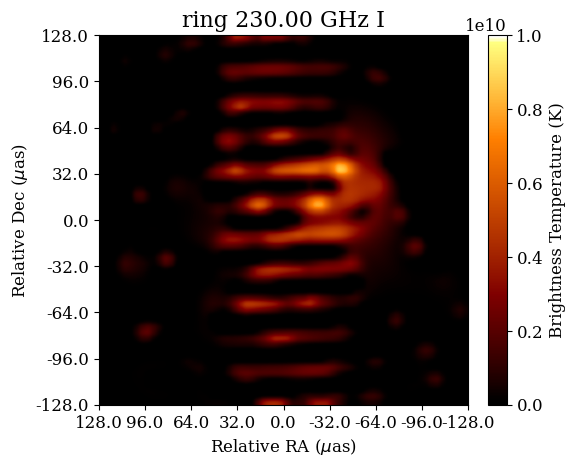

2023-10-18 14:57:06,933 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 14:57:06,935 INFO Display              :: Penalty--> 259.143864615567
2023-10-18 14:57:07,213 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 14:57:07,215 INFO Display              :: Penalty--> 252.05583169010075
2023-10-18 14:57:07,447 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 14:57:07,448 INFO Display              :: Penalty--> 249.19505163903307
2023-10-18 14:57:07,683 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 14:57:07,685 INFO Display              :: Penalty--> 247.6535782955383
2023-10-18 14:57:07,920 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 14:57:07,922 INFO Display              :: Penalty--> 245.00050336480345
2023-10-18 14:57:08,207 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 14:57:08,209 INFO Display              :: Penalty--> 243.37299496877236
2023-10-18 14:57:08,444 INFO CountIterations      :: iteration = 7 / 25
2

630.9130143718082
Data Fidelity:  350.7375015518563


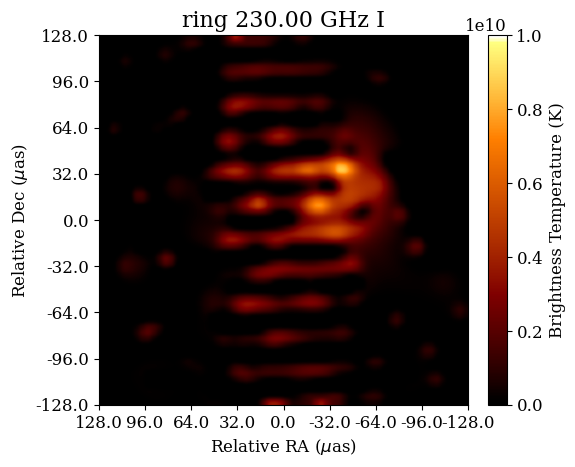

2023-10-18 14:57:14,058 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 14:57:14,059 INFO Display              :: Penalty--> 204.5847126299329
2023-10-18 14:57:14,291 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 14:57:14,293 INFO Display              :: Penalty--> 200.12662854475278
2023-10-18 14:57:14,528 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 14:57:14,530 INFO Display              :: Penalty--> 194.4930675975101
2023-10-18 14:57:14,777 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 14:57:14,778 INFO Display              :: Penalty--> 192.44850854570205
2023-10-18 14:57:15,045 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 14:57:15,046 INFO Display              :: Penalty--> 192.08844870532974
2023-10-18 14:57:15,288 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 14:57:15,289 INFO Display              :: Penalty--> 191.3740649182014
2023-10-18 14:57:15,537 INFO CountIterations      :: iteration = 7 / 25
2

653.187303706185
Data Fidelity:  349.11679228233595


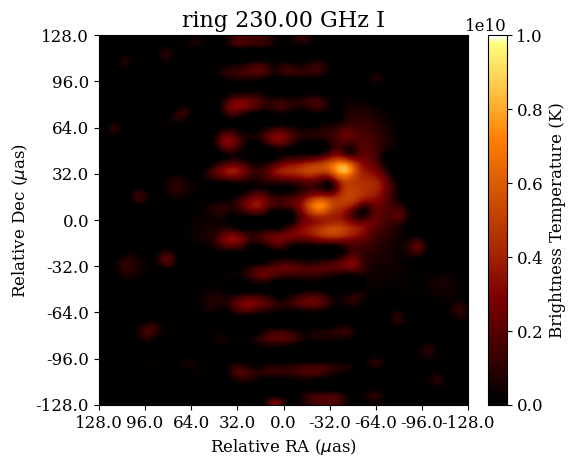

2023-10-18 14:57:20,639 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 14:57:20,641 INFO Display              :: Penalty--> 165.0782952085557
2023-10-18 14:57:20,873 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 14:57:20,875 INFO Display              :: Penalty--> 163.1247571896461
2023-10-18 14:57:21,105 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 14:57:21,107 INFO Display              :: Penalty--> 162.3946701717714
2023-10-18 14:57:21,370 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 14:57:21,372 INFO Display              :: Penalty--> 161.65692219555808
2023-10-18 14:57:21,601 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 14:57:21,603 INFO Display              :: Penalty--> 161.11950770195074
2023-10-18 14:57:21,841 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 14:57:21,843 INFO Display              :: Penalty--> 159.07825171006377
2023-10-18 14:57:22,141 INFO CountIterations      :: iteration = 7 / 25
2

1112.2788489277218
Data Fidelity:  557.016217144904


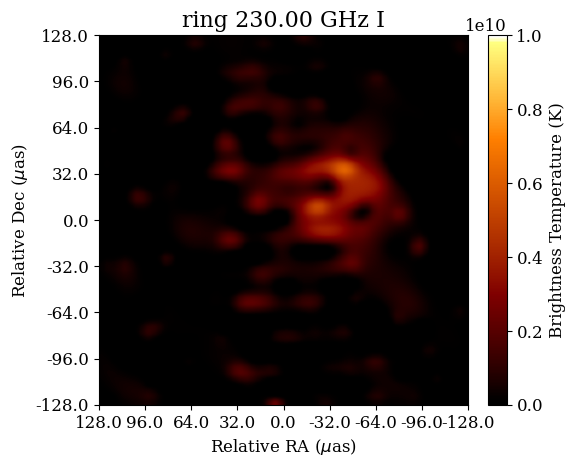

2023-10-18 14:57:27,564 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 14:57:27,566 INFO Display              :: Penalty--> 96.00005182733362
2023-10-18 14:57:27,799 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 14:57:27,800 INFO Display              :: Penalty--> 85.86194341607653
2023-10-18 14:57:28,110 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 14:57:28,111 INFO Display              :: Penalty--> 81.19795891490757
2023-10-18 14:57:28,346 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 14:57:28,348 INFO Display              :: Penalty--> 75.79660948544222
2023-10-18 14:57:28,583 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 14:57:28,585 INFO Display              :: Penalty--> 73.27768985139508
2023-10-18 14:57:28,823 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 14:57:28,825 INFO Display              :: Penalty--> 71.11079125300817
2023-10-18 14:57:29,110 INFO CountIterations      :: iteration = 7 / 25
2023

1170.1384382864373
Data Fidelity:  553.531849538768


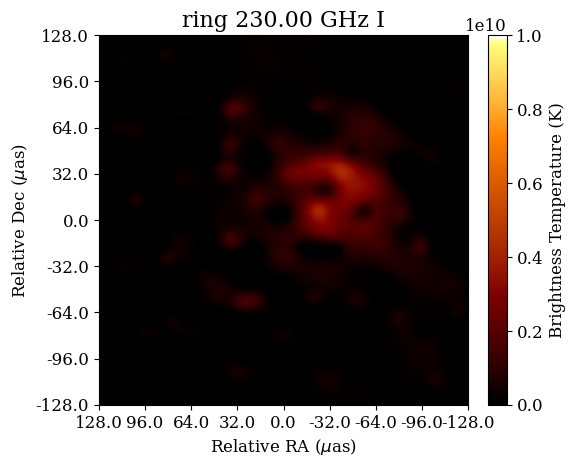

2023-10-18 14:57:34,635 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 14:57:34,637 INFO Display              :: Penalty--> 51.300015216268676
2023-10-18 14:57:34,908 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 14:57:34,909 INFO Display              :: Penalty--> 52.08603416540669
2023-10-18 14:57:35,214 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 14:57:35,215 INFO Display              :: Penalty--> 50.52320213202104
2023-10-18 14:57:35,463 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 14:57:35,464 INFO Display              :: Penalty--> 97.46294303135649
2023-10-18 14:57:35,714 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 14:57:35,715 INFO Display              :: Penalty--> 132.23604737914687
2023-10-18 14:57:35,962 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 14:57:35,963 INFO Display              :: Penalty--> 966.5133070695399
2023-10-18 14:57:36,248 INFO CountIterations      :: iteration = 7 / 25
20

11836.057504247952
Data Fidelity:  875.5476866470785


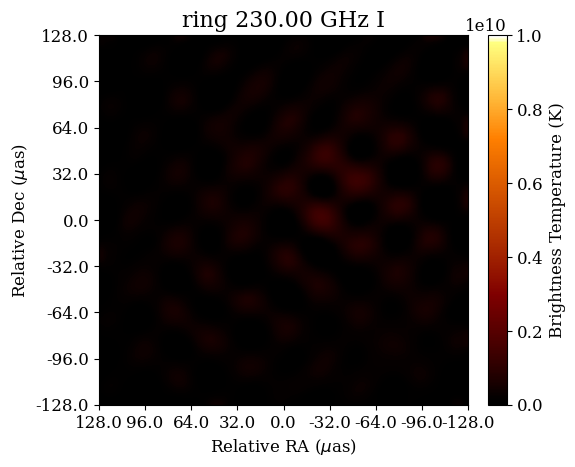

2023-10-18 14:57:41,605 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 14:57:41,607 INFO Display              :: Penalty--> 210.38802286647964
2023-10-18 14:57:41,889 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 14:57:41,891 INFO Display              :: Penalty--> 175.3839543960392
2023-10-18 14:57:42,181 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 14:57:42,187 INFO Display              :: Penalty--> 159.8165294337865
2023-10-18 14:57:42,451 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 14:57:42,453 INFO Display              :: Penalty--> 150.54156599326578
2023-10-18 14:57:42,753 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 14:57:42,755 INFO Display              :: Penalty--> 142.0893883224157
2023-10-18 14:57:43,006 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 14:57:43,008 INFO Display              :: Penalty--> 133.51602371643327
2023-10-18 14:57:43,256 INFO CountIterations      :: iteration = 7 / 25
2

642.0880107431562
Data Fidelity:  402.09341093248753


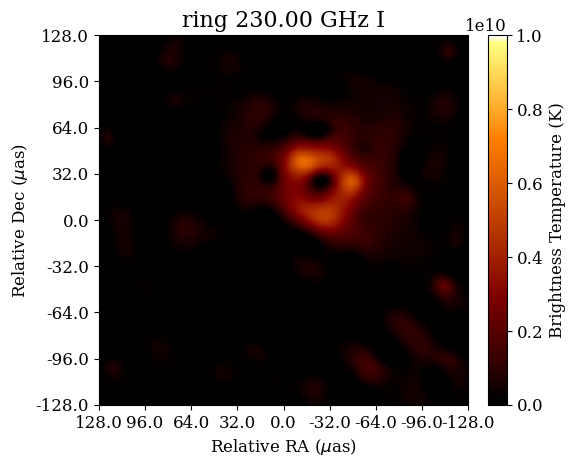

2023-10-18 14:57:48,758 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 14:57:48,760 INFO Display              :: Penalty--> 62.26845545961682
2023-10-18 14:57:49,016 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 14:57:49,017 INFO Display              :: Penalty--> 60.1230069666288
2023-10-18 14:57:49,271 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 14:57:49,272 INFO Display              :: Penalty--> 59.998902909238566
2023-10-18 14:57:49,525 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 14:57:49,526 INFO Display              :: Penalty--> 56.65681272375597
2023-10-18 14:57:49,779 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 14:57:49,780 INFO Display              :: Penalty--> 55.14645709909143
2023-10-18 14:57:50,041 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 14:57:50,043 INFO Display              :: Penalty--> 54.161641482609326
2023-10-18 14:57:50,342 INFO CountIterations      :: iteration = 7 / 25
202

533.5846376557674
Data Fidelity:  652.7306771248636


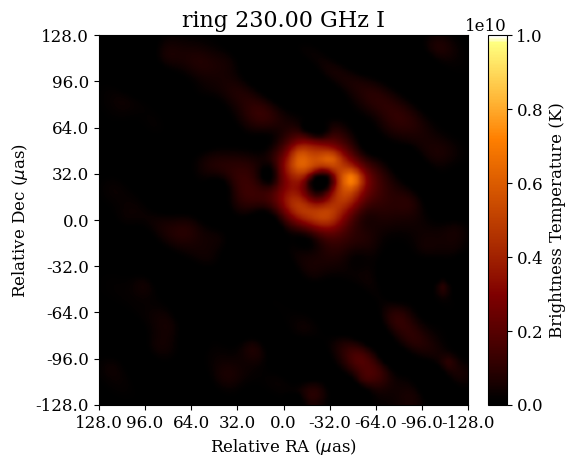

2023-10-18 14:57:56,281 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 14:57:56,283 INFO Display              :: Penalty--> 71.53724033030632
2023-10-18 14:57:56,568 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 14:57:56,570 INFO Display              :: Penalty--> 63.09065071404569
2023-10-18 14:57:56,840 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 14:57:56,842 INFO Display              :: Penalty--> 53.15745213217319
2023-10-18 14:57:57,135 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 14:57:57,137 INFO Display              :: Penalty--> 45.07973765991777
2023-10-18 14:57:57,411 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 14:57:57,413 INFO Display              :: Penalty--> 40.7911331819506
2023-10-18 14:57:57,657 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 14:57:57,659 INFO Display              :: Penalty--> 39.44893328102197
2023-10-18 14:57:57,949 INFO CountIterations      :: iteration = 7 / 25
2023-

634.4792167771375
Data Fidelity:  422.8410452856413


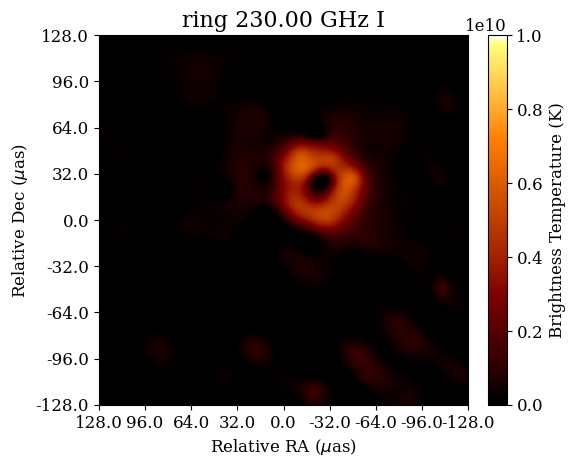

In [14]:
#Regularization parameters
alpha = 0.5
tau = 10
noise_levels = np.ones(len(widths))

wtfcts = handler.second_round(init, tau, alpha*noise_levels, maxiter=15, max_iterations=25, display=True)

reco = handler.op(wtfcts)        
img = handler.wrapper.formatoutput(np.maximum(0, reco))

The recovered solution during the first iterations represents noise-like fringes. Note that this is caused by the large stepsize parameter causing divergence. However, the coercivity of the penalty term brings the solution back in the right ballpark. After some time the forward-backward splitting starts to converge and recovers a ring-like feature. Significant improvements in speed and accuracy are possible by reasonable initial guesses and will be matter of tutorial 5 and tutorial 6. To achieve global convergence, we blur the reconstruction by the instrumental resolution and repeat the minimization with smaller stepsizes  from this initial guess.

2023-10-18 14:58:16,692 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 14:58:16,693 INFO Display              :: Penalty--> 905.3395545725956
2023-10-18 14:58:16,928 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 14:58:16,930 INFO Display              :: Penalty--> 848.1103418440276
2023-10-18 14:58:17,172 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 14:58:17,173 INFO Display              :: Penalty--> 837.8257297651822
2023-10-18 14:58:17,423 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 14:58:17,424 INFO Display              :: Penalty--> 828.3598861001774
2023-10-18 14:58:17,676 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 14:58:17,677 INFO Display              :: Penalty--> 820.2663529707146
2023-10-18 14:58:17,922 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 14:58:17,923 INFO Display              :: Penalty--> 811.3150329177583
2023-10-18 14:58:18,186 INFO CountIterations      :: iteration = 7 / 25
2023

2299.5088599458772
Data Fidelity:  903.7582170001397


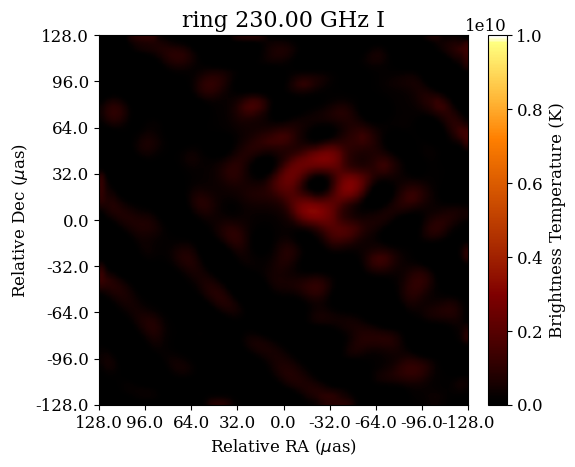

2023-10-18 14:58:23,356 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 14:58:23,357 INFO Display              :: Penalty--> 116.4587000214809
2023-10-18 14:58:23,598 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 14:58:23,599 INFO Display              :: Penalty--> 91.63990928283467
2023-10-18 14:58:23,846 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 14:58:23,848 INFO Display              :: Penalty--> 74.50887174263067
2023-10-18 14:58:24,118 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 14:58:24,120 INFO Display              :: Penalty--> 67.24322463376316
2023-10-18 14:58:24,371 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 14:58:24,374 INFO Display              :: Penalty--> 60.18748778337422
2023-10-18 14:58:24,618 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 14:58:24,620 INFO Display              :: Penalty--> 242.1928984160713
2023-10-18 14:58:24,866 INFO CountIterations      :: iteration = 7 / 25
2023

731.3589643965212
Data Fidelity:  355.94111191137085


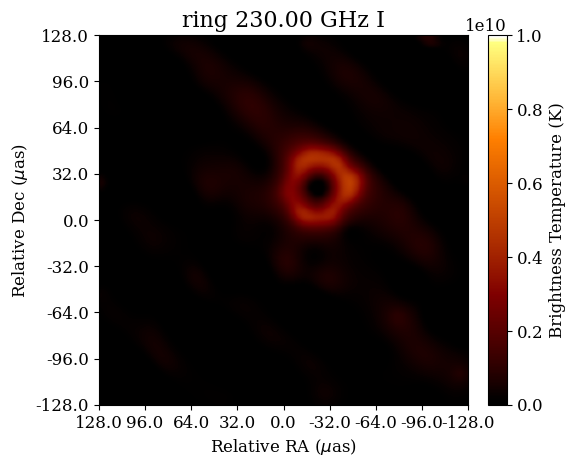

2023-10-18 14:58:30,254 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 14:58:30,255 INFO Display              :: Penalty--> 101.4428970027184
2023-10-18 14:58:30,574 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 14:58:30,575 INFO Display              :: Penalty--> 97.45919866662885
2023-10-18 14:58:30,870 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 14:58:30,872 INFO Display              :: Penalty--> 93.62144216483956
2023-10-18 14:58:31,168 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 14:58:31,171 INFO Display              :: Penalty--> 89.27078508022802
2023-10-18 14:58:31,428 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 14:58:31,430 INFO Display              :: Penalty--> 85.14727598830623
2023-10-18 14:58:31,667 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 14:58:31,668 INFO Display              :: Penalty--> 81.53973128459289
2023-10-18 14:58:31,915 INFO CountIterations      :: iteration = 7 / 25
2023

496.9250972236151
Data Fidelity:  338.8669220085954


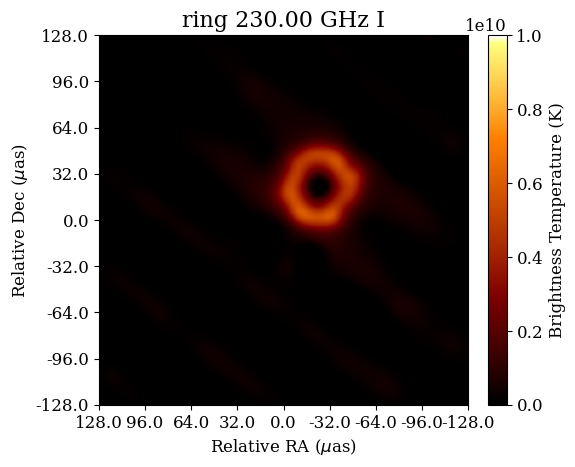

2023-10-18 14:58:37,416 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 14:58:37,417 INFO Display              :: Penalty--> 93.59808895679076
2023-10-18 14:58:37,661 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 14:58:37,662 INFO Display              :: Penalty--> 90.78651724651218
2023-10-18 14:58:37,911 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 14:58:37,913 INFO Display              :: Penalty--> 84.97682949040929
2023-10-18 14:58:38,238 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 14:58:38,239 INFO Display              :: Penalty--> 76.9404841931825
2023-10-18 14:58:38,467 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 14:58:38,469 INFO Display              :: Penalty--> 69.10370686067711
2023-10-18 14:58:38,736 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 14:58:38,737 INFO Display              :: Penalty--> 60.834085382038914
2023-10-18 14:58:39,031 INFO CountIterations      :: iteration = 7 / 25
2023

558.1497348997616
Data Fidelity:  14.79278368251903


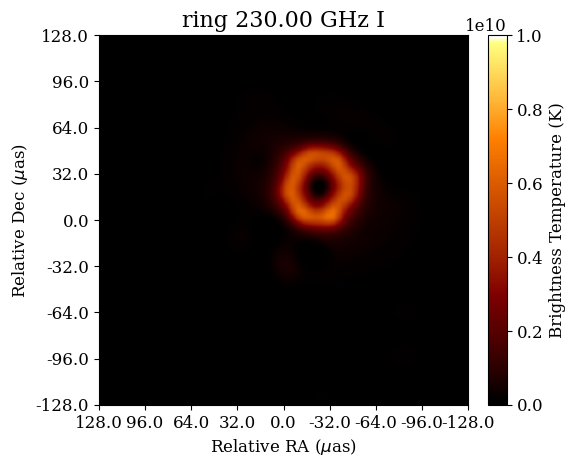

2023-10-18 14:58:44,808 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 14:58:44,810 INFO Display              :: Penalty--> 32.81183312688299
2023-10-18 14:58:45,075 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 14:58:45,076 INFO Display              :: Penalty--> 32.8083856956306
2023-10-18 14:58:45,313 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 14:58:45,315 INFO Display              :: Penalty--> 32.763569089349595
2023-10-18 14:58:45,555 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 14:58:45,557 INFO Display              :: Penalty--> 32.71300676431461
2023-10-18 14:58:45,789 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 14:58:45,790 INFO Display              :: Penalty--> 32.66129529552883
2023-10-18 14:58:46,022 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 14:58:46,024 INFO Display              :: Penalty--> 32.650953001771676
2023-10-18 14:58:46,308 INFO CountIterations      :: iteration = 7 / 25
202

562.7101021547847
Data Fidelity:  9.214623663037486


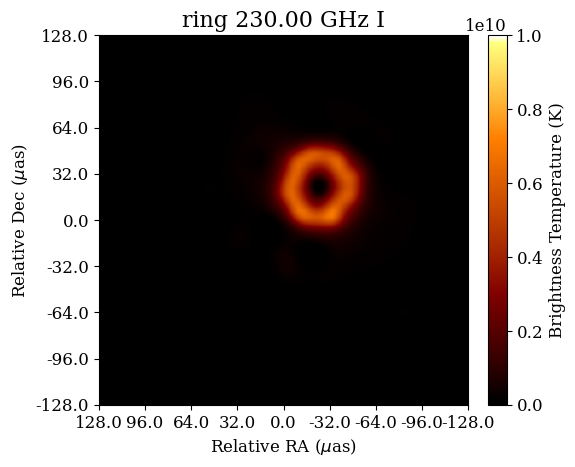

2023-10-18 14:58:51,712 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 14:58:51,714 INFO Display              :: Penalty--> 31.925460825052333
2023-10-18 14:58:51,950 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 14:58:51,952 INFO Display              :: Penalty--> 31.925460825052333
2023-10-18 14:58:52,186 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 14:58:52,188 INFO Display              :: Penalty--> 31.925460825052333
2023-10-18 14:58:52,490 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 14:58:52,492 INFO Display              :: Penalty--> 31.91435243546131
2023-10-18 14:58:52,759 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 14:58:52,761 INFO Display              :: Penalty--> 31.885240793774507
2023-10-18 14:58:53,031 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 14:58:53,033 INFO Display              :: Penalty--> 31.8477020979152
2023-10-18 14:58:53,326 INFO CountIterations      :: iteration = 7 / 25
2

577.5067212199833
Data Fidelity:  6.786998410402086


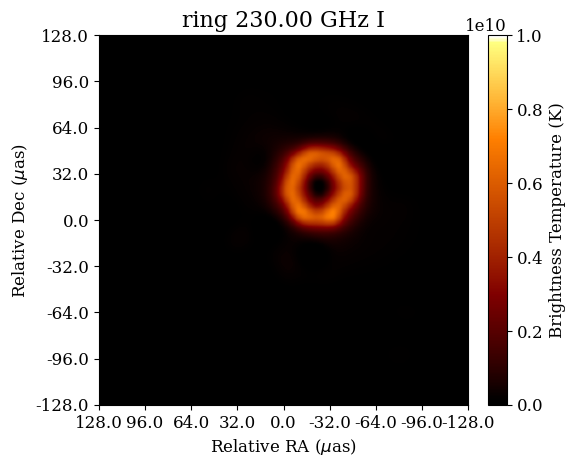

2023-10-18 14:58:58,806 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 14:58:58,808 INFO Display              :: Penalty--> 31.38995983718184
2023-10-18 14:58:59,105 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 14:58:59,107 INFO Display              :: Penalty--> 31.38995983718184
2023-10-18 14:58:59,341 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 14:58:59,343 INFO Display              :: Penalty--> 31.3761701121723
2023-10-18 14:58:59,584 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 14:58:59,586 INFO Display              :: Penalty--> 31.372722680919914
2023-10-18 14:58:59,832 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 14:58:59,833 INFO Display              :: Penalty--> 31.342078847565375
2023-10-18 14:59:00,116 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 14:59:00,118 INFO Display              :: Penalty--> 31.334417889226742
2023-10-18 14:59:00,400 INFO CountIterations      :: iteration = 7 / 25
20

585.1043283725705
Data Fidelity:  5.330365215418804


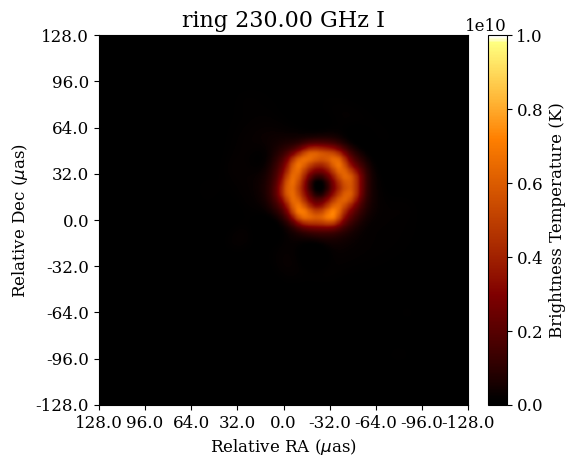

2023-10-18 14:59:05,996 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 14:59:05,998 INFO Display              :: Penalty--> 30.607394098788948
2023-10-18 14:59:06,237 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 14:59:06,239 INFO Display              :: Penalty--> 30.599733140450315
2023-10-18 14:59:06,532 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 14:59:06,534 INFO Display              :: Penalty--> 30.59628570919793
2023-10-18 14:59:06,769 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 14:59:06,771 INFO Display              :: Penalty--> 30.592838277945546
2023-10-18 14:59:07,007 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 14:59:07,009 INFO Display              :: Penalty--> 30.585177319606913
2023-10-18 14:59:07,245 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 14:59:07,246 INFO Display              :: Penalty--> 30.579048552936005
2023-10-18 14:59:07,540 INFO CountIterations      :: iteration = 7 / 25

587.808946789379
Data Fidelity:  4.442221249576806


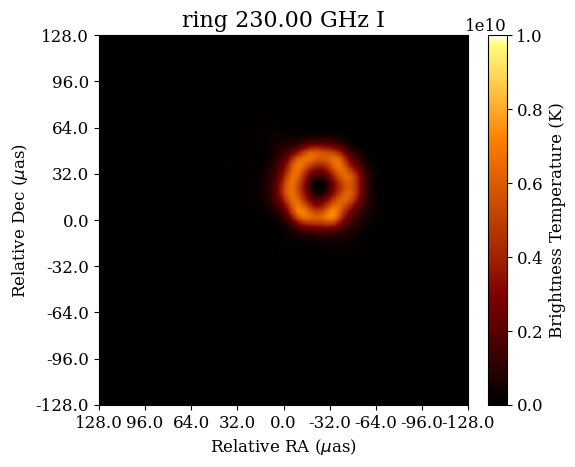

2023-10-18 14:59:12,812 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 14:59:12,814 INFO Display              :: Penalty--> 30.16344156306512
2023-10-18 14:59:13,049 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 14:59:13,051 INFO Display              :: Penalty--> 30.16344156306512
2023-10-18 14:59:13,286 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 14:59:13,288 INFO Display              :: Penalty--> 30.16344156306512
2023-10-18 14:59:13,524 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 14:59:13,525 INFO Display              :: Penalty--> 30.132797729710582
2023-10-18 14:59:13,767 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 14:59:13,768 INFO Display              :: Penalty--> 30.1293502984582
2023-10-18 14:59:14,001 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 14:59:14,003 INFO Display              :: Penalty--> 30.1293502984582
2023-10-18 14:59:14,259 INFO CountIterations      :: iteration = 7 / 25
2023-

591.8403318133127
Data Fidelity:  3.8502421762555645


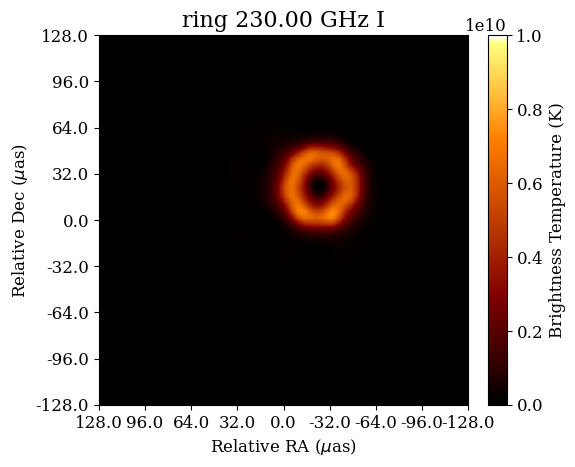

2023-10-18 14:59:19,139 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 14:59:19,141 INFO Display              :: Penalty--> 29.927484046235207
2023-10-18 14:59:19,400 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 14:59:19,401 INFO Display              :: Penalty--> 29.919823087896575
2023-10-18 14:59:19,657 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 14:59:19,658 INFO Display              :: Penalty--> 29.919823087896575
2023-10-18 14:59:19,894 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 14:59:19,895 INFO Display              :: Penalty--> 29.901819835800783
2023-10-18 14:59:20,129 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 14:59:20,131 INFO Display              :: Penalty--> 29.891477542043628
2023-10-18 14:59:20,361 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 14:59:20,363 INFO Display              :: Penalty--> 29.81946453366047
2023-10-18 14:59:20,599 INFO CountIterations      :: iteration = 7 / 25

593.5671613796297
Data Fidelity:  3.3748926834472597


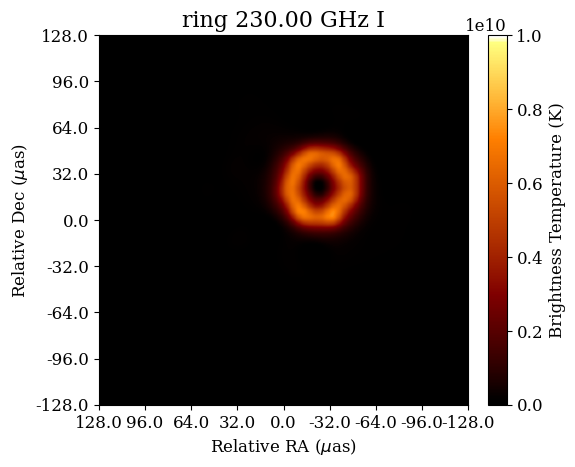

2023-10-18 14:59:25,554 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 14:59:25,556 INFO Display              :: Penalty--> 29.593466262670777
2023-10-18 14:59:25,793 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 14:59:25,795 INFO Display              :: Penalty--> 29.582740920996688
2023-10-18 14:59:26,025 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 14:59:26,026 INFO Display              :: Penalty--> 29.582740920996688
2023-10-18 14:59:26,257 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 14:59:26,259 INFO Display              :: Penalty--> 29.580059585578166
2023-10-18 14:59:26,493 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 14:59:26,494 INFO Display              :: Penalty--> 29.57239862723953
2023-10-18 14:59:26,730 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 14:59:26,732 INFO Display              :: Penalty--> 29.57239862723953
2023-10-18 14:59:26,967 INFO CountIterations      :: iteration = 7 / 25


594.1913463229778
Data Fidelity:  3.0369190370649486


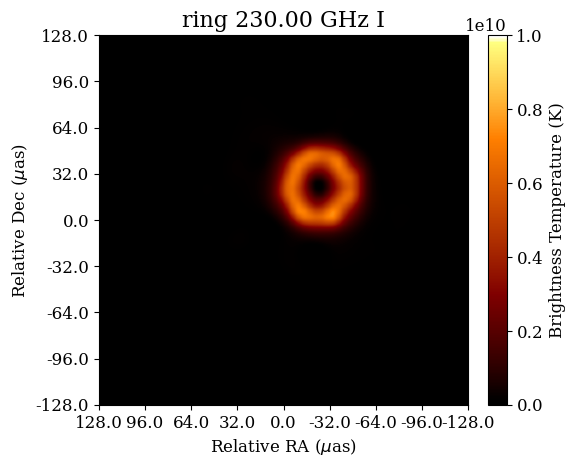

2023-10-18 14:59:31,911 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 14:59:31,913 INFO Display              :: Penalty--> 29.375895045853575
2023-10-18 14:59:32,150 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 14:59:32,151 INFO Display              :: Penalty--> 29.33912244582813
2023-10-18 14:59:32,387 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 14:59:32,388 INFO Display              :: Penalty--> 29.33912244582813
2023-10-18 14:59:32,623 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 14:59:32,624 INFO Display              :: Penalty--> 29.336441110409613
2023-10-18 14:59:32,859 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 14:59:32,861 INFO Display              :: Penalty--> 29.32878015207098
2023-10-18 14:59:33,097 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 14:59:33,098 INFO Display              :: Penalty--> 29.298136318716445
2023-10-18 14:59:33,333 INFO CountIterations      :: iteration = 7 / 25
2

594.797957778421
Data Fidelity:  2.745290520923585


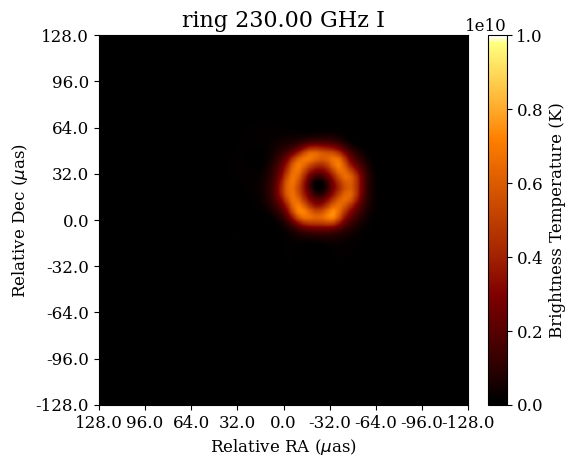

2023-10-18 14:59:38,236 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 14:59:38,237 INFO Display              :: Penalty--> 29.05873137063414
2023-10-18 14:59:38,487 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 14:59:38,489 INFO Display              :: Penalty--> 29.055283939381752
2023-10-18 14:59:38,748 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 14:59:38,749 INFO Display              :: Penalty--> 29.055283939381752
2023-10-18 14:59:38,995 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 14:59:38,996 INFO Display              :: Penalty--> 29.055283939381752
2023-10-18 14:59:39,242 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 14:59:39,243 INFO Display              :: Penalty--> 29.055283939381752
2023-10-18 14:59:39,491 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 14:59:39,492 INFO Display              :: Penalty--> 29.021192674774834
2023-10-18 14:59:39,761 INFO CountIterations      :: iteration = 7 / 25

595.9158686253224
Data Fidelity:  2.5112007649117585


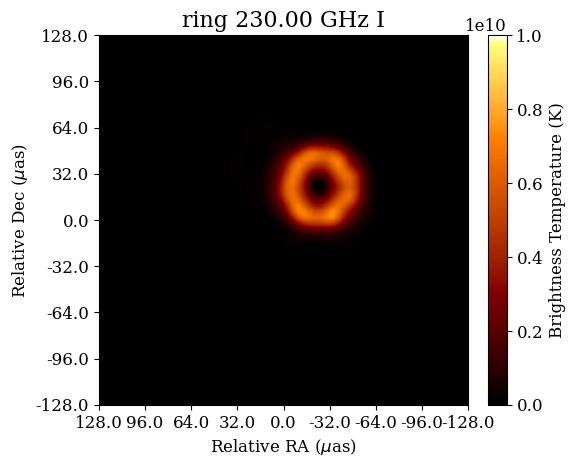

2023-10-18 14:59:44,888 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 14:59:44,890 INFO Display              :: Penalty--> 28.870654843420674
2023-10-18 14:59:45,142 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 14:59:45,144 INFO Display              :: Penalty--> 28.859929501746592
2023-10-18 14:59:45,398 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 14:59:45,400 INFO Display              :: Penalty--> 28.85724816632807
2023-10-18 14:59:45,654 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 14:59:45,655 INFO Display              :: Penalty--> 28.849587207989433
2023-10-18 14:59:45,904 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 14:59:45,906 INFO Display              :: Penalty--> 28.849587207989433
2023-10-18 14:59:46,160 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 14:59:46,161 INFO Display              :: Penalty--> 28.807834985043886
2023-10-18 14:59:46,411 INFO CountIterations      :: iteration = 7 / 25

596.162392434275
Data Fidelity:  2.311315424628743


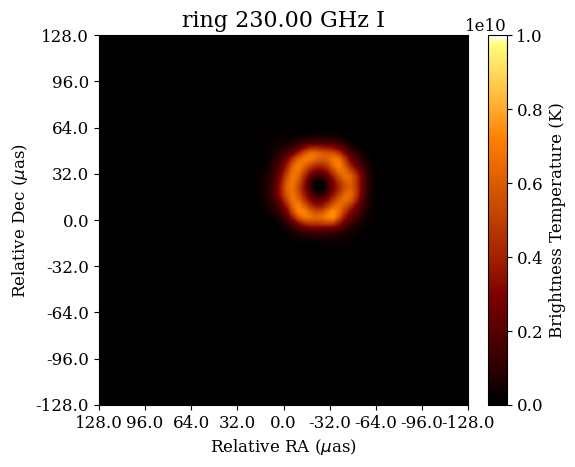

2023-10-18 14:59:51,584 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 14:59:51,586 INFO Display              :: Penalty--> 28.495651510693833
2023-10-18 14:59:51,836 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 14:59:51,837 INFO Display              :: Penalty--> 28.489522744022924
2023-10-18 14:59:52,088 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 14:59:52,090 INFO Display              :: Penalty--> 28.489522744022924
2023-10-18 14:59:52,351 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 14:59:52,352 INFO Display              :: Penalty--> 28.486075312770538
2023-10-18 14:59:52,602 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 14:59:52,603 INFO Display              :: Penalty--> 28.482627881518155
2023-10-18 14:59:52,853 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 14:59:52,855 INFO Display              :: Penalty--> 28.476499114847247
2023-10-18 14:59:53,105 INFO CountIterations      :: iteration = 7 / 2

597.0962667416579
Data Fidelity:  2.1461519750393485


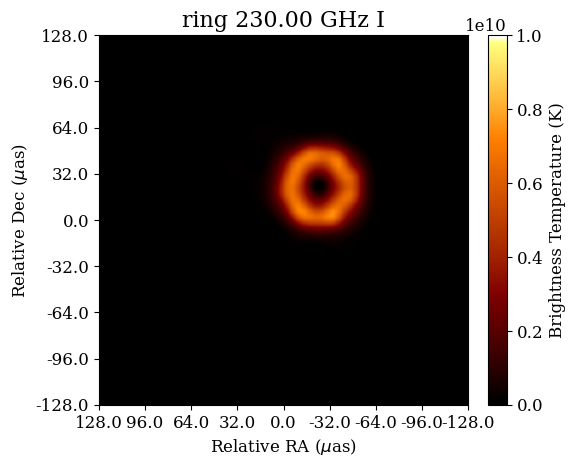

2023-10-18 14:59:58,352 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 14:59:58,353 INFO Display              :: Penalty--> 28.312171558483556
2023-10-18 14:59:58,600 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 14:59:58,601 INFO Display              :: Penalty--> 28.312171558483556
2023-10-18 14:59:58,852 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 14:59:58,853 INFO Display              :: Penalty--> 28.305276695978787
2023-10-18 14:59:59,106 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 14:59:59,107 INFO Display              :: Penalty--> 28.305276695978787
2023-10-18 14:59:59,358 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 14:59:59,360 INFO Display              :: Penalty--> 28.305276695978787
2023-10-18 14:59:59,606 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 14:59:59,608 INFO Display              :: Penalty--> 28.294551354304698
2023-10-18 14:59:59,857 INFO CountIterations      :: iteration = 7 / 2

597.2957390323486
Data Fidelity:  2.0141688866021243


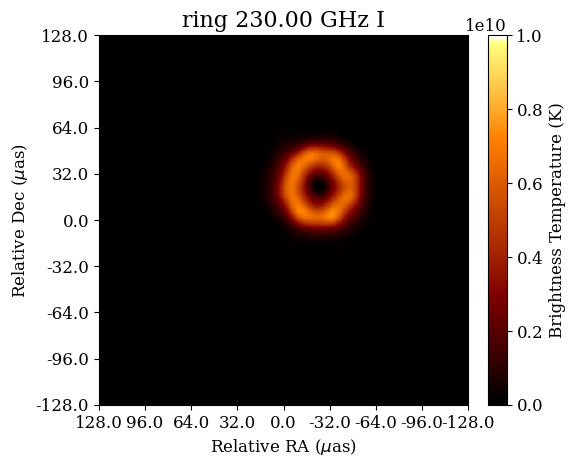

2023-10-18 15:00:04,991 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:00:04,993 INFO Display              :: Penalty--> 28.24283988551892
2023-10-18 15:00:05,435 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:00:05,437 INFO Display              :: Penalty--> 28.24283988551892
2023-10-18 15:00:05,672 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:00:05,673 INFO Display              :: Penalty--> 28.24283988551892
2023-10-18 15:00:05,907 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:00:05,908 INFO Display              :: Penalty--> 28.21219605216438
2023-10-18 15:00:06,142 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:00:06,143 INFO Display              :: Penalty--> 28.208748620911997
2023-10-18 15:00:06,377 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:00:06,378 INFO Display              :: Penalty--> 28.208748620911997
2023-10-18 15:00:06,612 INFO CountIterations      :: iteration = 7 / 25
20

597.5133268630393
Data Fidelity:  1.8997444908676544


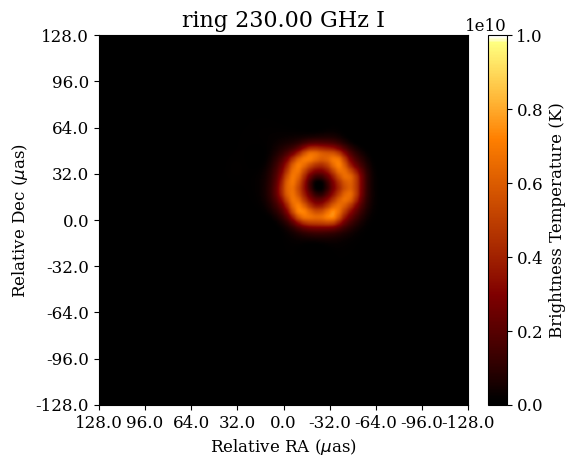

2023-10-18 15:00:11,695 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:00:11,697 INFO Display              :: Penalty--> 28.085024143743063
2023-10-18 15:00:11,997 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:00:11,998 INFO Display              :: Penalty--> 28.085024143743063
2023-10-18 15:00:12,240 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:00:12,241 INFO Display              :: Penalty--> 28.08234280832454
2023-10-18 15:00:12,486 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:00:12,487 INFO Display              :: Penalty--> 28.08234280832454
2023-10-18 15:00:12,771 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:00:12,773 INFO Display              :: Penalty--> 28.08234280832454
2023-10-18 15:00:13,007 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:00:13,008 INFO Display              :: Penalty--> 28.08234280832454
2023-10-18 15:00:13,241 INFO CountIterations      :: iteration = 7 / 25
20

597.9052827777973
Data Fidelity:  1.8002443806971922


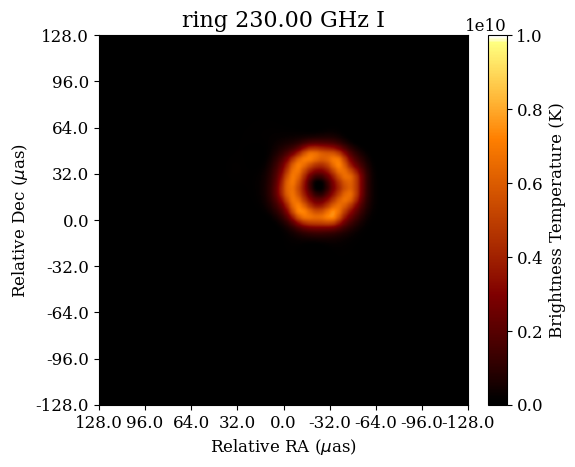

2023-10-18 15:00:18,827 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:00:18,828 INFO Display              :: Penalty--> 28.03867534579433
2023-10-18 15:00:19,103 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:00:19,105 INFO Display              :: Penalty--> 28.035227914541945
2023-10-18 15:00:19,346 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:00:19,347 INFO Display              :: Penalty--> 28.027566956203312
2023-10-18 15:00:19,595 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:00:19,597 INFO Display              :: Penalty--> 28.027566956203312
2023-10-18 15:00:19,843 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:00:19,845 INFO Display              :: Penalty--> 28.027566956203312
2023-10-18 15:00:20,147 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:00:20,148 INFO Display              :: Penalty--> 28.027566956203312
2023-10-18 15:00:20,386 INFO CountIterations      :: iteration = 7 / 25

598.202620343503
Data Fidelity:  1.7109541087760354


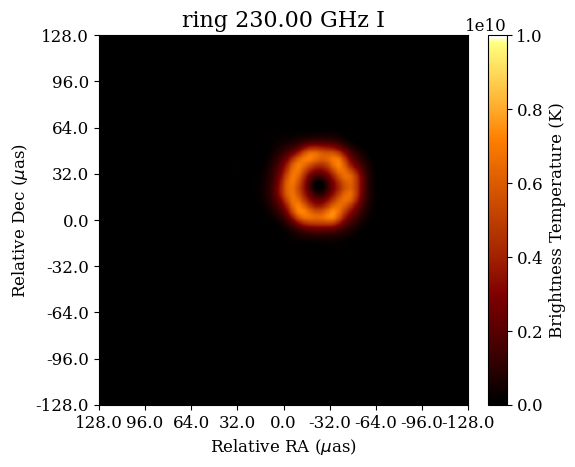

2023-10-18 15:00:25,534 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:00:25,536 INFO Display              :: Penalty--> 27.957086139487878
2023-10-18 15:00:25,771 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:00:25,772 INFO Display              :: Penalty--> 27.957086139487878
2023-10-18 15:00:26,009 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:00:26,011 INFO Display              :: Penalty--> 27.95363870823549
2023-10-18 15:00:26,243 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:00:26,244 INFO Display              :: Penalty--> 27.947509941564586
2023-10-18 15:00:26,477 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:00:26,478 INFO Display              :: Penalty--> 27.947509941564586
2023-10-18 15:00:26,709 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:00:26,711 INFO Display              :: Penalty--> 27.947509941564586
2023-10-18 15:00:26,941 INFO CountIterations      :: iteration = 7 / 25

597.773919045128
Data Fidelity:  1.6298547838135335


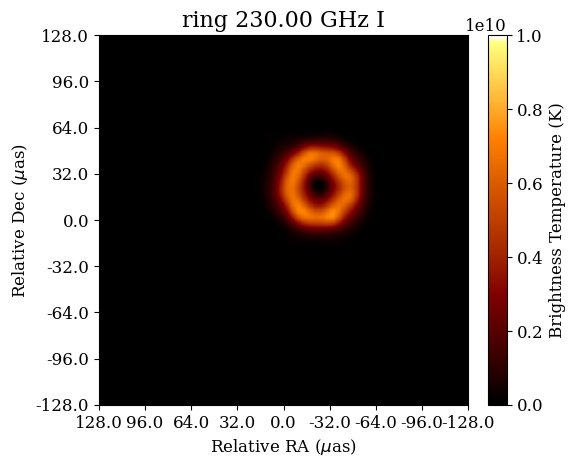

2023-10-18 15:00:31,831 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:00:31,832 INFO Display              :: Penalty--> 27.779734953948513
2023-10-18 15:00:32,063 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:00:32,064 INFO Display              :: Penalty--> 27.776287522696126
2023-10-18 15:00:32,296 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:00:32,298 INFO Display              :: Penalty--> 27.776287522696126
2023-10-18 15:00:32,540 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:00:32,541 INFO Display              :: Penalty--> 27.776287522696126
2023-10-18 15:00:32,780 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:00:32,781 INFO Display              :: Penalty--> 27.770158756025218
2023-10-18 15:00:33,016 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:00:33,017 INFO Display              :: Penalty--> 27.766711324772835
2023-10-18 15:00:33,251 INFO CountIterations      :: iteration = 7 / 2

598.2785363916549
Data Fidelity:  1.5602688088717163


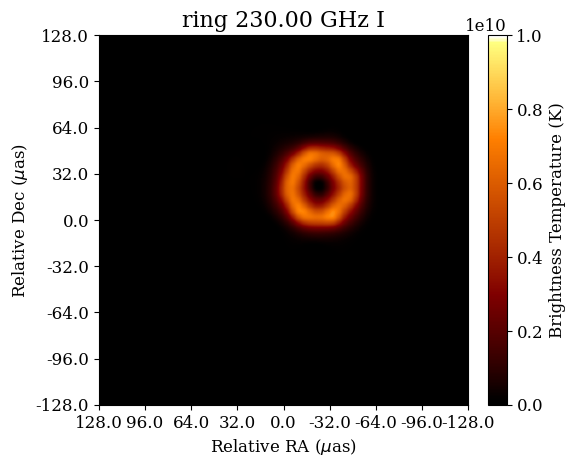

2023-10-18 15:00:38,205 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:00:38,206 INFO Display              :: Penalty--> 27.668651058038318
2023-10-18 15:00:38,441 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:00:38,443 INFO Display              :: Penalty--> 27.668651058038318
2023-10-18 15:00:38,676 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:00:38,678 INFO Display              :: Penalty--> 27.662522291367413
2023-10-18 15:00:38,911 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:00:38,912 INFO Display              :: Penalty--> 27.497046169202196
2023-10-18 15:00:39,146 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:00:39,148 INFO Display              :: Penalty--> 27.485937779611177
2023-10-18 15:00:39,382 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:00:39,384 INFO Display              :: Penalty--> 27.485937779611177
2023-10-18 15:00:39,620 INFO CountIterations      :: iteration = 7 / 2

598.4523719367612
Data Fidelity:  1.4925041193433315


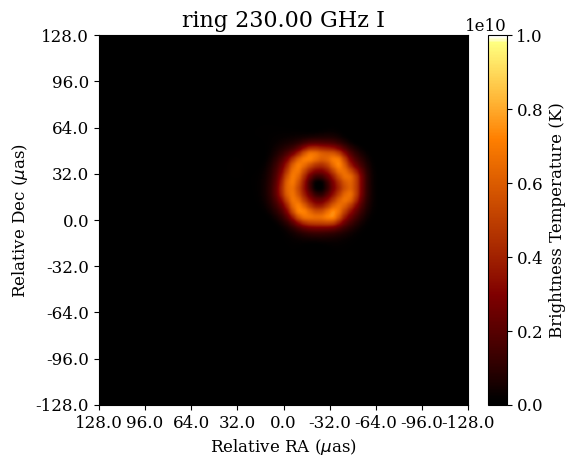

2023-10-18 15:00:44,529 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:00:44,530 INFO Display              :: Penalty--> 27.424650112902107
2023-10-18 15:00:44,762 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:00:44,764 INFO Display              :: Penalty--> 27.424650112902107
2023-10-18 15:00:45,001 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:00:45,003 INFO Display              :: Penalty--> 27.424650112902107
2023-10-18 15:00:45,249 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:00:45,250 INFO Display              :: Penalty--> 27.424650112902107
2023-10-18 15:00:45,493 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:00:45,494 INFO Display              :: Penalty--> 27.413541723311088
2023-10-18 15:00:45,739 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:00:45,741 INFO Display              :: Penalty--> 27.413541723311088
2023-10-18 15:00:45,981 INFO CountIterations      :: iteration = 7 / 2

598.6720236048293
Data Fidelity:  1.4331958919042358


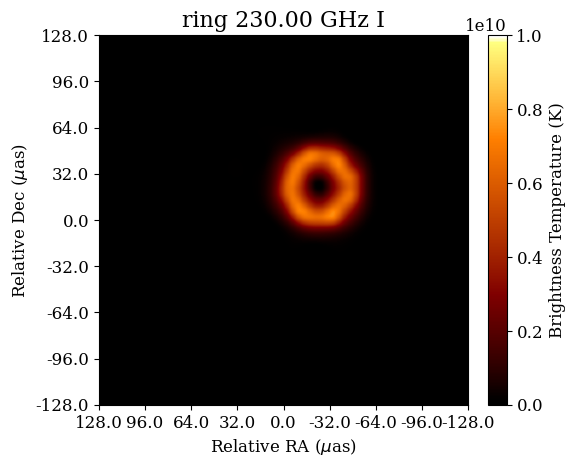

2023-10-18 15:00:50,889 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:00:50,890 INFO Display              :: Penalty--> 27.204398138615662
2023-10-18 15:00:51,133 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:00:51,134 INFO Display              :: Penalty--> 27.19673718027703
2023-10-18 15:00:51,380 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:00:51,381 INFO Display              :: Penalty--> 27.19673718027703
2023-10-18 15:00:51,623 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:00:51,624 INFO Display              :: Penalty--> 27.19673718027703
2023-10-18 15:00:51,864 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:00:51,865 INFO Display              :: Penalty--> 27.186394886519878
2023-10-18 15:00:52,104 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:00:52,105 INFO Display              :: Penalty--> 27.186394886519878
2023-10-18 15:00:52,339 INFO CountIterations      :: iteration = 7 / 25
2

598.4482394799979
Data Fidelity:  1.3855140000492012


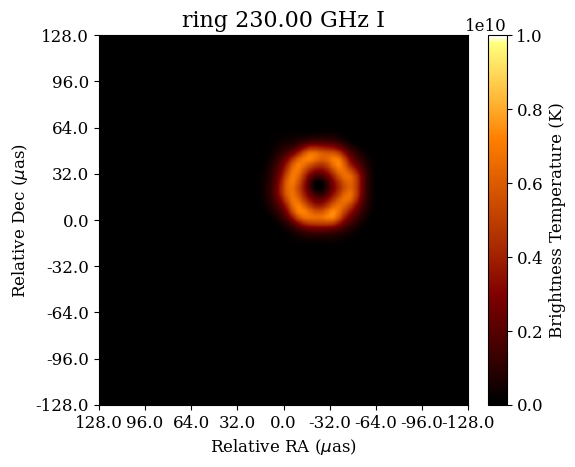

2023-10-18 15:00:57,737 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:00:57,738 INFO Display              :: Penalty--> 27.16954077817488
2023-10-18 15:00:58,011 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:00:58,013 INFO Display              :: Penalty--> 27.16954077817488
2023-10-18 15:00:58,298 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:00:58,300 INFO Display              :: Penalty--> 27.16954077817488
2023-10-18 15:00:58,597 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:00:58,598 INFO Display              :: Penalty--> 27.16954077817488
2023-10-18 15:00:58,872 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:00:58,873 INFO Display              :: Penalty--> 27.16954077817488
2023-10-18 15:00:59,184 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:00:59,186 INFO Display              :: Penalty--> 27.166093346922494
2023-10-18 15:00:59,418 INFO CountIterations      :: iteration = 7 / 25
202

598.4106053344058
Data Fidelity:  1.338115862056037


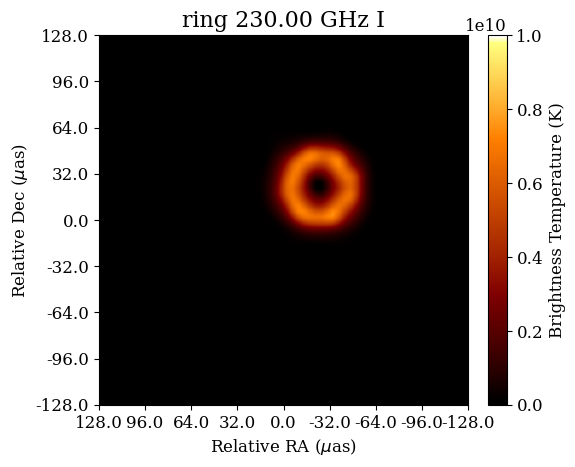

2023-10-18 15:01:04,865 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:01:04,866 INFO Display              :: Penalty--> 395.04117302626094
2023-10-18 15:01:05,163 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:01:05,165 INFO Display              :: Penalty--> 375.4527245417937
2023-10-18 15:01:05,470 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:01:05,471 INFO Display              :: Penalty--> 359.82029948224385
2023-10-18 15:01:05,757 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:01:05,758 INFO Display              :: Penalty--> 348.6361471010609
2023-10-18 15:01:06,015 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:01:06,016 INFO Display              :: Penalty--> 341.16180512612215
2023-10-18 15:01:06,254 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:01:06,255 INFO Display              :: Penalty--> 335.6561792933882
2023-10-18 15:01:06,501 INFO CountIterations      :: iteration = 7 / 25
2

520.9695046256444
Data Fidelity:  68.7509235427624


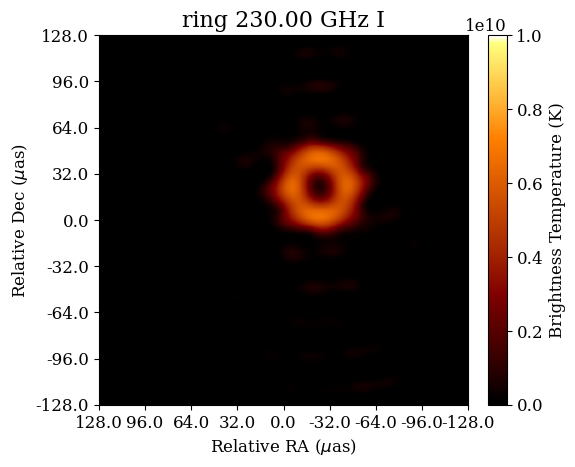

2023-10-18 15:01:12,129 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:01:12,130 INFO Display              :: Penalty--> 263.36741329456146
2023-10-18 15:01:12,381 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:01:12,383 INFO Display              :: Penalty--> 263.36741329456146
2023-10-18 15:01:12,658 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:01:12,659 INFO Display              :: Penalty--> 263.36741329456146
2023-10-18 15:01:12,926 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:01:12,928 INFO Display              :: Penalty--> 263.11000567233265
2023-10-18 15:01:13,177 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:01:13,179 INFO Display              :: Penalty--> 263.01807417226905
2023-10-18 15:01:13,415 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:01:13,417 INFO Display              :: Penalty--> 261.96392977256863
2023-10-18 15:01:13,652 INFO CountIterations      :: iteration = 7 / 2

589.9172604484095
Data Fidelity:  19.911717149763472


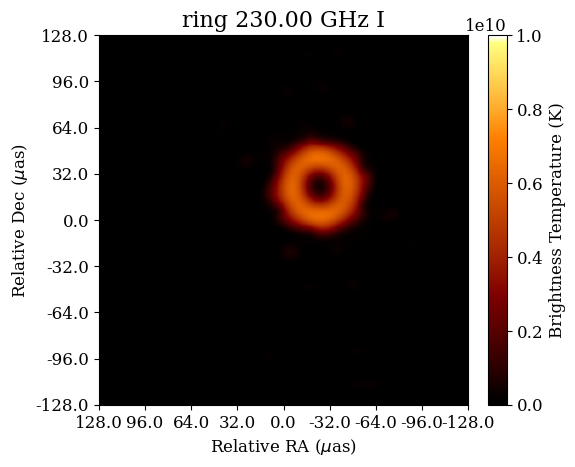

2023-10-18 15:01:19,043 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:01:19,045 INFO Display              :: Penalty--> 221.78573651709607
2023-10-18 15:01:19,289 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:01:19,290 INFO Display              :: Penalty--> 220.5661159952305
2023-10-18 15:01:19,532 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:01:19,534 INFO Display              :: Penalty--> 219.9471122953167
2023-10-18 15:01:19,774 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:01:19,776 INFO Display              :: Penalty--> 218.55282192333027
2023-10-18 15:01:20,012 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:01:20,014 INFO Display              :: Penalty--> 217.3332014014647
2023-10-18 15:01:20,250 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:01:20,251 INFO Display              :: Penalty--> 215.27983282551648
2023-10-18 15:01:20,485 INFO CountIterations      :: iteration = 7 / 25
2

589.5011631409219
Data Fidelity:  5.168794035181013


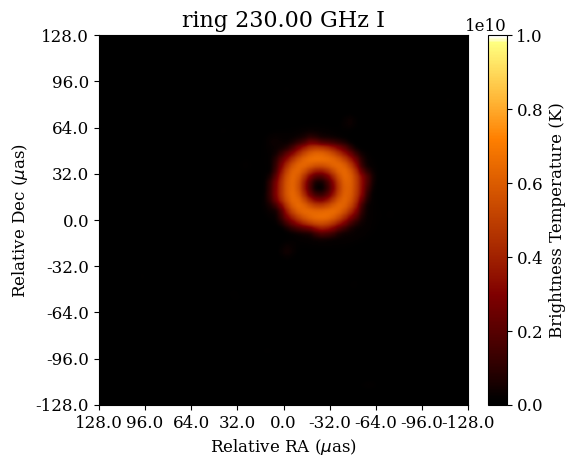

2023-10-18 15:01:25,675 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:01:25,677 INFO Display              :: Penalty--> 196.99797581238423
2023-10-18 15:01:25,918 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:01:25,920 INFO Display              :: Penalty--> 196.9060443123206
2023-10-18 15:01:26,187 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:01:26,189 INFO Display              :: Penalty--> 196.87540047896607
2023-10-18 15:01:26,425 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:01:26,426 INFO Display              :: Penalty--> 196.53678727629702
2023-10-18 15:01:26,660 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:01:26,661 INFO Display              :: Penalty--> 195.7059592342186
2023-10-18 15:01:26,940 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:01:26,942 INFO Display              :: Penalty--> 195.5021783203602
2023-10-18 15:01:27,197 INFO CountIterations      :: iteration = 7 / 25
2

591.6836412026513
Data Fidelity:  2.9366891403046504


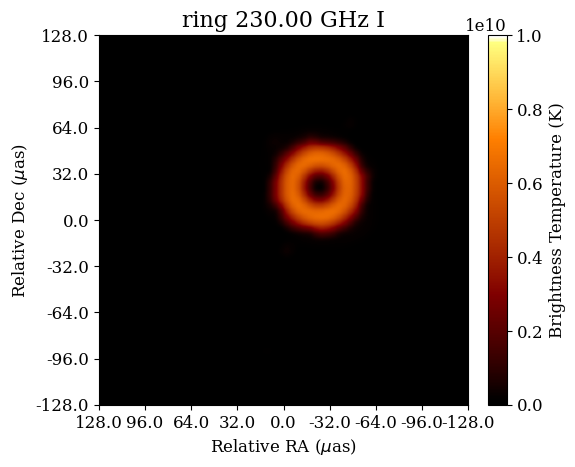

2023-10-18 15:01:32,591 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:01:32,592 INFO Display              :: Penalty--> 191.14301201325645
2023-10-18 15:01:32,823 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:01:32,825 INFO Display              :: Penalty--> 191.14301201325645
2023-10-18 15:01:33,110 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:01:33,112 INFO Display              :: Penalty--> 190.97753589109124
2023-10-18 15:01:33,358 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:01:33,360 INFO Display              :: Penalty--> 190.9128007931298
2023-10-18 15:01:33,600 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:01:33,601 INFO Display              :: Penalty--> 190.88215695977527
2023-10-18 15:01:33,830 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:01:33,832 INFO Display              :: Penalty--> 190.85151312642074
2023-10-18 15:01:34,066 INFO CountIterations      :: iteration = 7 / 25

595.3156562333255
Data Fidelity:  2.208229227771688


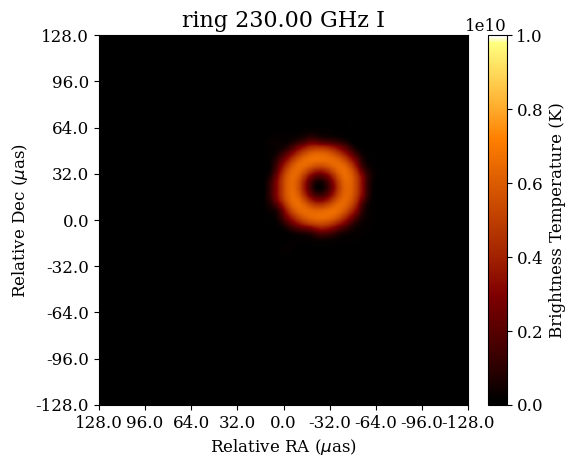

2023-10-18 15:01:39,288 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:01:39,289 INFO Display              :: Penalty--> 188.2915176836017
2023-10-18 15:01:39,554 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:01:39,556 INFO Display              :: Penalty--> 188.2915176836017
2023-10-18 15:01:39,823 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:01:39,824 INFO Display              :: Penalty--> 188.2501485085731
2023-10-18 15:01:40,105 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:01:40,106 INFO Display              :: Penalty--> 188.17813550018994
2023-10-18 15:01:40,368 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:01:40,370 INFO Display              :: Penalty--> 188.17813550018994
2023-10-18 15:01:40,606 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:01:40,607 INFO Display              :: Penalty--> 188.17813550018994
2023-10-18 15:01:40,860 INFO CountIterations      :: iteration = 7 / 25
2

597.111362109908
Data Fidelity:  1.8266835228483014


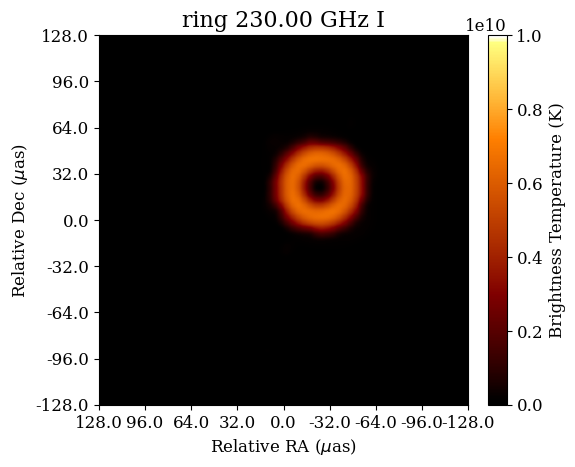

2023-10-18 15:01:46,624 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:01:46,625 INFO Display              :: Penalty--> 187.3250895230309
2023-10-18 15:01:46,918 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:01:46,919 INFO Display              :: Penalty--> 187.28372034800228
2023-10-18 15:01:47,184 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:01:47,185 INFO Display              :: Penalty--> 187.2224326812932
2023-10-18 15:01:47,440 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:01:47,442 INFO Display              :: Penalty--> 187.2224326812932
2023-10-18 15:01:47,678 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:01:47,680 INFO Display              :: Penalty--> 187.05695655912803
2023-10-18 15:01:47,929 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:01:47,930 INFO Display              :: Penalty--> 186.8914804369628
2023-10-18 15:01:48,184 INFO CountIterations      :: iteration = 7 / 25
20

597.8068290033985
Data Fidelity:  1.5674515536977311


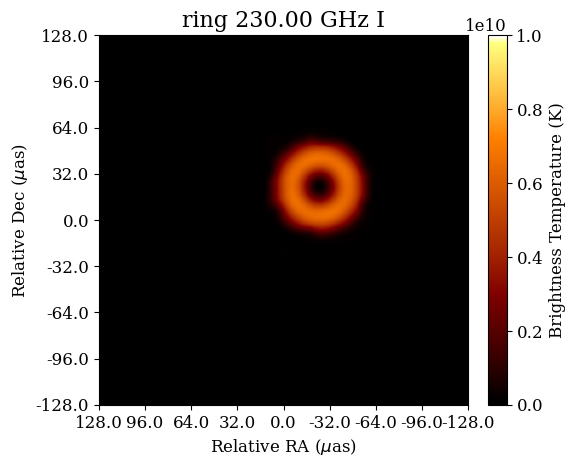

2023-10-18 15:01:53,606 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:01:53,607 INFO Display              :: Penalty--> 186.17211702691438
2023-10-18 15:01:53,928 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:01:53,929 INFO Display              :: Penalty--> 186.1613916852403
2023-10-18 15:01:54,190 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:01:54,192 INFO Display              :: Penalty--> 186.06946018517667
2023-10-18 15:01:54,441 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:01:54,442 INFO Display              :: Penalty--> 185.87334022965692
2023-10-18 15:01:54,757 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:01:54,758 INFO Display              :: Penalty--> 185.87334022965692
2023-10-18 15:01:55,001 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:01:55,002 INFO Display              :: Penalty--> 185.87334022965692
2023-10-18 15:01:55,254 INFO CountIterations      :: iteration = 7 / 25

598.2888928141385
Data Fidelity:  1.3883713937963647


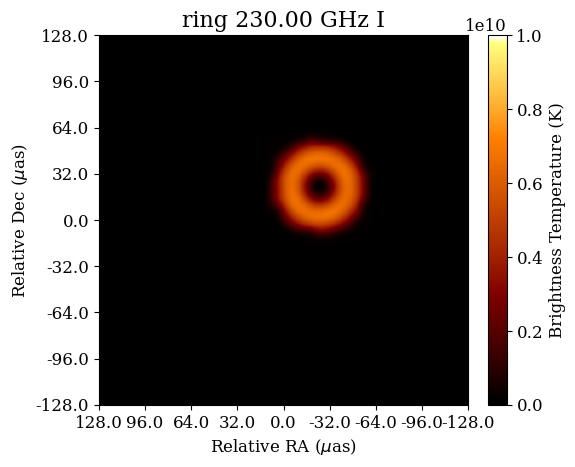

2023-10-18 15:02:01,003 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:02:01,005 INFO Display              :: Penalty--> 185.08119829334075
2023-10-18 15:02:01,276 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:02:01,277 INFO Display              :: Penalty--> 185.04289350164757
2023-10-18 15:02:01,539 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:02:01,541 INFO Display              :: Penalty--> 185.04289350164757
2023-10-18 15:02:01,838 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:02:01,840 INFO Display              :: Penalty--> 184.9816058349385
2023-10-18 15:02:02,091 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:02:02,092 INFO Display              :: Penalty--> 184.9816058349385
2023-10-18 15:02:02,340 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:02:02,341 INFO Display              :: Penalty--> 184.79774341276055
2023-10-18 15:02:02,591 INFO CountIterations      :: iteration = 7 / 25


599.0683063394406
Data Fidelity:  1.2789530838008238


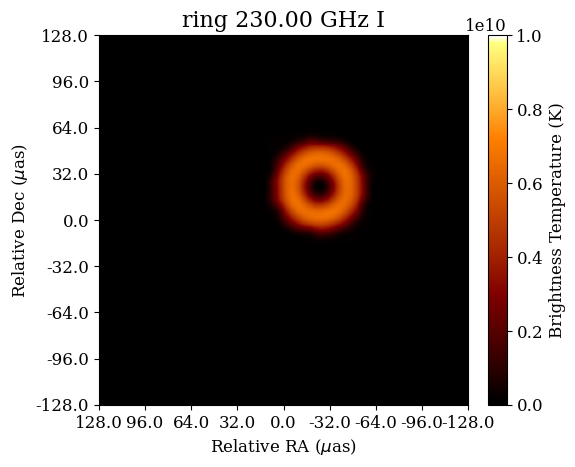

2023-10-18 15:02:08,111 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:02:08,112 INFO Display              :: Penalty--> 184.53573863757927
2023-10-18 15:02:08,347 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:02:08,349 INFO Display              :: Penalty--> 184.53573863757927
2023-10-18 15:02:08,583 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:02:08,585 INFO Display              :: Penalty--> 184.53573863757927
2023-10-18 15:02:08,869 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:02:08,870 INFO Display              :: Penalty--> 184.53573863757927
2023-10-18 15:02:09,117 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:02:09,119 INFO Display              :: Penalty--> 184.53573863757927
2023-10-18 15:02:09,405 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:02:09,406 INFO Display              :: Penalty--> 184.33961868205952
2023-10-18 15:02:09,648 INFO CountIterations      :: iteration = 7 / 2

599.5731236638095
Data Fidelity:  1.2023258937541321


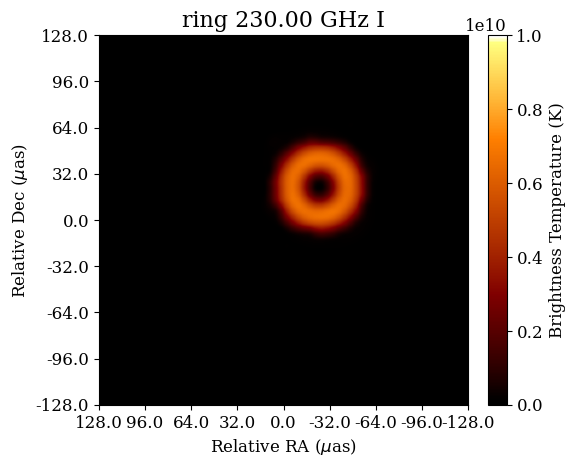

2023-10-18 15:02:15,356 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:02:15,357 INFO Display              :: Penalty--> 183.99181175143485
2023-10-18 15:02:15,597 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:02:15,598 INFO Display              :: Penalty--> 183.99181175143485
2023-10-18 15:02:15,830 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:02:15,831 INFO Display              :: Penalty--> 183.93052408472576
2023-10-18 15:02:16,061 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:02:16,063 INFO Display              :: Penalty--> 183.89221929303258
2023-10-18 15:02:16,333 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:02:16,334 INFO Display              :: Penalty--> 183.89221929303258
2023-10-18 15:02:16,583 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:02:16,585 INFO Display              :: Penalty--> 183.89221929303258
2023-10-18 15:02:16,855 INFO CountIterations      :: iteration = 7 / 2

599.4555204457455
Data Fidelity:  1.1311824344180832


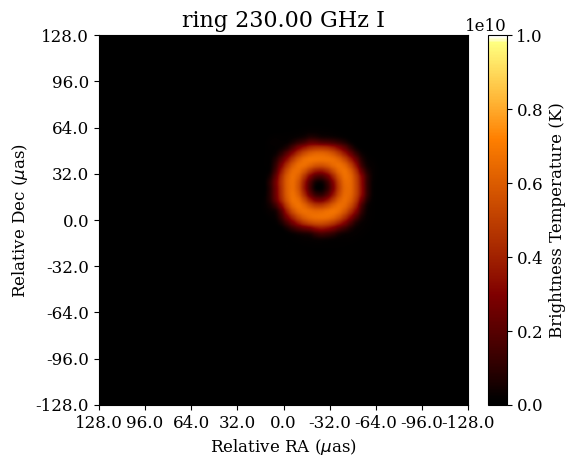

2023-10-18 15:02:22,463 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:02:22,464 INFO Display              :: Penalty--> 183.71946468249644
2023-10-18 15:02:22,702 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:02:22,711 INFO Display              :: Penalty--> 183.71946468249644
2023-10-18 15:02:22,994 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:02:23,003 INFO Display              :: Penalty--> 183.71946468249644
2023-10-18 15:02:23,237 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:02:23,239 INFO Display              :: Penalty--> 183.70873934082235
2023-10-18 15:02:23,536 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:02:23,538 INFO Display              :: Penalty--> 183.67809550746782
2023-10-18 15:02:23,772 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:02:23,774 INFO Display              :: Penalty--> 183.64477033869477
2023-10-18 15:02:24,021 INFO CountIterations      :: iteration = 7 / 2

599.8343645155991
Data Fidelity:  1.0705228328983232


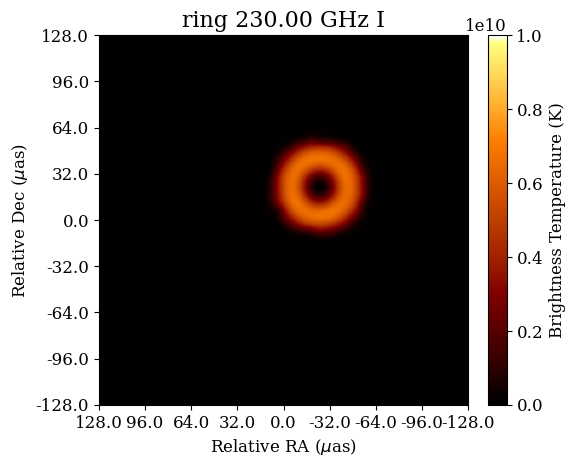

2023-10-18 15:02:29,708 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:02:29,709 INFO Display              :: Penalty--> 182.79363960112033
2023-10-18 15:02:29,999 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:02:30,000 INFO Display              :: Penalty--> 182.79363960112033
2023-10-18 15:02:30,255 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:02:30,256 INFO Display              :: Penalty--> 182.79363960112033
2023-10-18 15:02:30,487 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:02:30,489 INFO Display              :: Penalty--> 182.79363960112033
2023-10-18 15:02:30,722 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:02:30,723 INFO Display              :: Penalty--> 182.73235193441127
2023-10-18 15:02:31,013 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:02:31,015 INFO Display              :: Penalty--> 182.72162659273718
2023-10-18 15:02:31,274 INFO CountIterations      :: iteration = 7 / 2

600.1269546739363
Data Fidelity:  1.0241471074926172


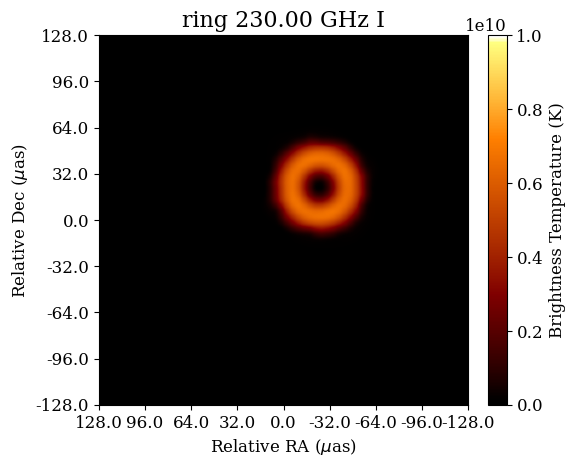

2023-10-18 15:02:36,613 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:02:36,614 INFO Display              :: Penalty--> 182.3355148704193
2023-10-18 15:02:36,855 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:02:36,856 INFO Display              :: Penalty--> 182.3355148704193
2023-10-18 15:02:37,089 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:02:37,090 INFO Display              :: Penalty--> 182.3355148704193
2023-10-18 15:02:37,378 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:02:37,380 INFO Display              :: Penalty--> 182.3355148704193
2023-10-18 15:02:37,613 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:02:37,614 INFO Display              :: Penalty--> 182.3355148704193
2023-10-18 15:02:37,850 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:02:37,851 INFO Display              :: Penalty--> 182.3355148704193
2023-10-18 15:02:38,111 INFO CountIterations      :: iteration = 7 / 25
2023

600.0793157463929
Data Fidelity:  0.9908508959573765


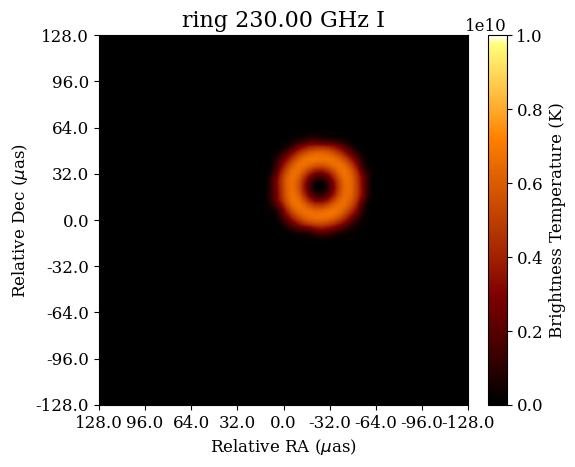

2023-10-18 15:02:43,568 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:02:43,569 INFO Display              :: Penalty--> 182.07121238568573
2023-10-18 15:02:43,863 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:02:43,865 INFO Display              :: Penalty--> 182.04976170233755
2023-10-18 15:02:44,095 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:02:44,097 INFO Display              :: Penalty--> 181.8536417468178
2023-10-18 15:02:44,328 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:02:44,329 INFO Display              :: Penalty--> 181.82299791346327
2023-10-18 15:02:44,565 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:02:44,566 INFO Display              :: Penalty--> 181.82299791346327
2023-10-18 15:02:44,802 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:02:44,803 INFO Display              :: Penalty--> 181.82299791346327
2023-10-18 15:02:45,037 INFO CountIterations      :: iteration = 7 / 25

600.0664296264258
Data Fidelity:  0.9554278234418554


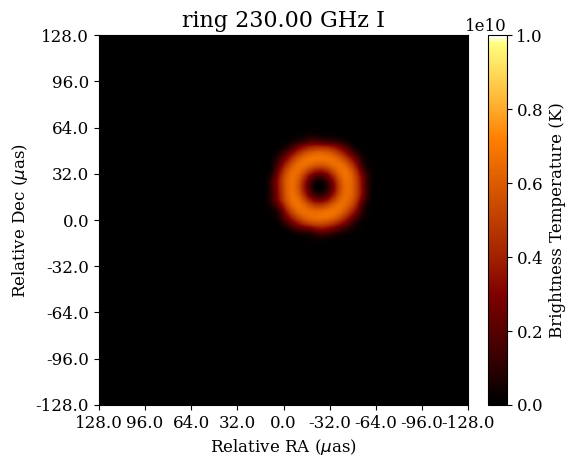

2023-10-18 15:02:49,952 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:02:49,953 INFO Display              :: Penalty--> 181.67897189669694
2023-10-18 15:02:50,193 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:02:50,194 INFO Display              :: Penalty--> 181.67897189669694
2023-10-18 15:02:50,432 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:02:50,434 INFO Display              :: Penalty--> 181.67897189669694
2023-10-18 15:02:50,682 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:02:50,683 INFO Display              :: Penalty--> 181.6483280633424
2023-10-18 15:02:50,918 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:02:50,919 INFO Display              :: Penalty--> 181.6483280633424
2023-10-18 15:02:51,151 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:02:51,152 INFO Display              :: Penalty--> 181.61768422998787
2023-10-18 15:02:51,383 INFO CountIterations      :: iteration = 7 / 25


600.3933440584296
Data Fidelity:  0.9291969954217314


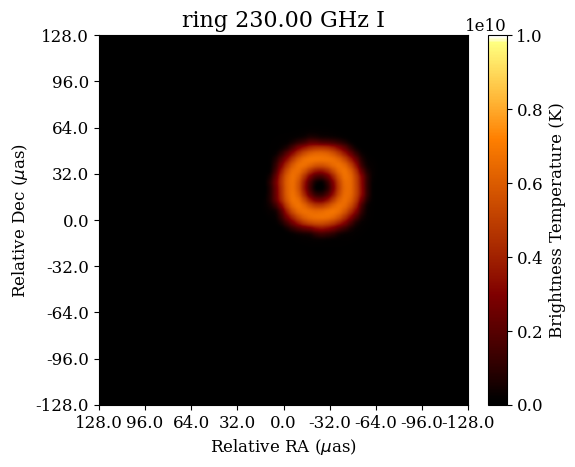

2023-10-18 15:02:56,335 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:02:56,336 INFO Display              :: Penalty--> 180.9655003105816
2023-10-18 15:02:56,571 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:02:56,572 INFO Display              :: Penalty--> 180.9655003105816
2023-10-18 15:02:56,807 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:02:56,808 INFO Display              :: Penalty--> 180.9655003105816
2023-10-18 15:02:57,042 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:02:57,043 INFO Display              :: Penalty--> 180.9655003105816
2023-10-18 15:02:57,275 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:02:57,276 INFO Display              :: Penalty--> 180.9655003105816
2023-10-18 15:02:57,511 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:02:57,512 INFO Display              :: Penalty--> 180.9655003105816
2023-10-18 15:02:57,751 INFO CountIterations      :: iteration = 7 / 25
2023

600.3858942102604
Data Fidelity:  0.9088508473729671


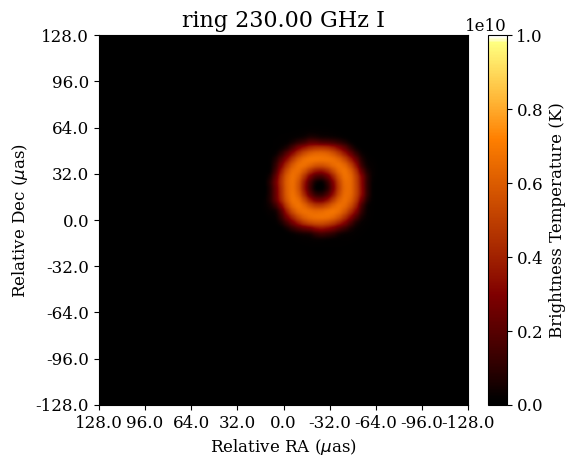

2023-10-18 15:03:02,644 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:03:02,646 INFO Display              :: Penalty--> 180.7601866271062
2023-10-18 15:03:02,881 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:03:02,890 INFO Display              :: Penalty--> 180.7601866271062
2023-10-18 15:03:03,128 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:03:03,130 INFO Display              :: Penalty--> 180.74946128543212
2023-10-18 15:03:03,366 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:03:03,368 INFO Display              :: Penalty--> 180.74946128543212
2023-10-18 15:03:03,604 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:03:03,606 INFO Display              :: Penalty--> 180.74946128543212
2023-10-18 15:03:03,841 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:03:03,842 INFO Display              :: Penalty--> 180.7188174520776
2023-10-18 15:03:04,092 INFO CountIterations      :: iteration = 7 / 25
2

600.4618857705179
Data Fidelity:  0.8905022911354956


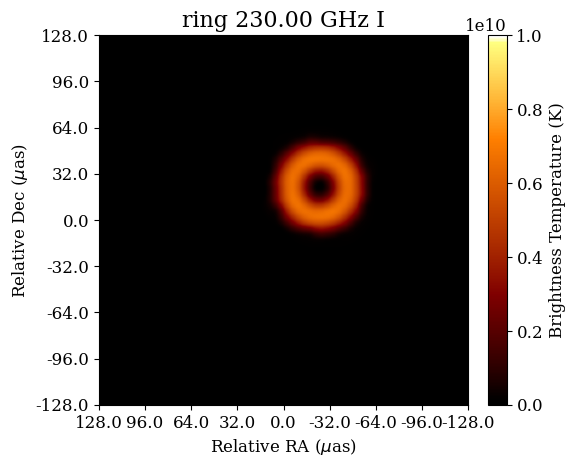

2023-10-18 15:03:09,071 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:03:09,072 INFO Display              :: Penalty--> 180.59202859157318
2023-10-18 15:03:09,305 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:03:09,307 INFO Display              :: Penalty--> 180.59202859157318
2023-10-18 15:03:09,542 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:03:09,544 INFO Display              :: Penalty--> 180.5813032498991
2023-10-18 15:03:09,779 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:03:09,781 INFO Display              :: Penalty--> 180.5813032498991
2023-10-18 15:03:10,015 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:03:10,017 INFO Display              :: Penalty--> 180.53993407487047
2023-10-18 15:03:10,257 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:03:10,259 INFO Display              :: Penalty--> 180.53993407487047
2023-10-18 15:03:10,496 INFO CountIterations      :: iteration = 7 / 25


600.4981007575628
Data Fidelity:  0.8746702316369114


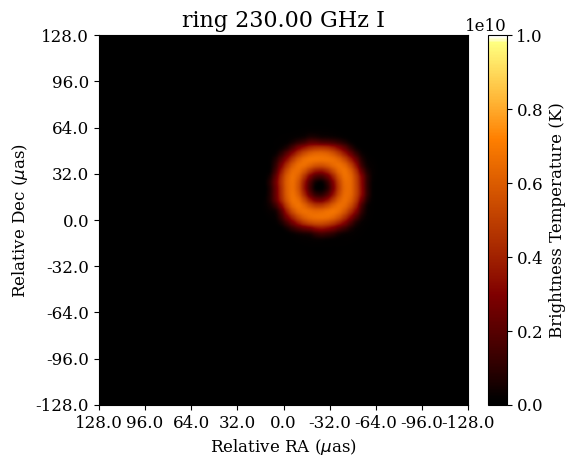

2023-10-18 15:03:15,514 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:03:15,516 INFO Display              :: Penalty--> 180.48017859982912
2023-10-18 15:03:15,752 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:03:15,753 INFO Display              :: Penalty--> 180.48017859982912
2023-10-18 15:03:16,032 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:03:16,034 INFO Display              :: Penalty--> 180.44953476647456
2023-10-18 15:03:16,319 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:03:16,321 INFO Display              :: Penalty--> 180.44953476647456
2023-10-18 15:03:16,590 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:03:16,593 INFO Display              :: Penalty--> 180.44187380813594
2023-10-18 15:03:16,854 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:03:16,857 INFO Display              :: Penalty--> 180.27639768597072
2023-10-18 15:03:17,096 INFO CountIterations      :: iteration = 7 / 2

600.2882856747428
Data Fidelity:  0.8597057442251613


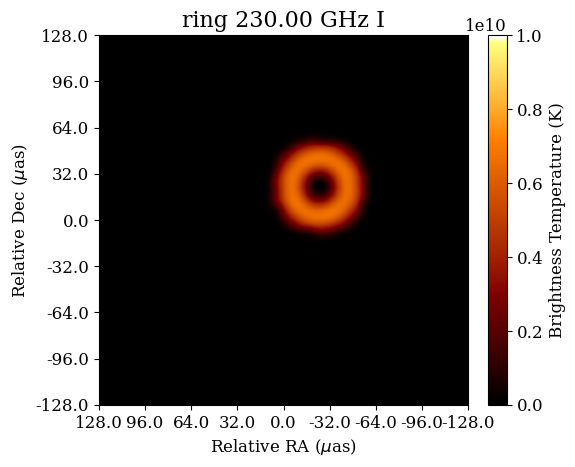

2023-10-18 15:03:22,592 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:03:22,594 INFO Display              :: Penalty--> 180.2216218338495
2023-10-18 15:03:22,880 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:03:22,881 INFO Display              :: Penalty--> 180.2108964921754
2023-10-18 15:03:23,173 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:03:23,175 INFO Display              :: Penalty--> 180.2108964921754
2023-10-18 15:03:23,409 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:03:23,410 INFO Display              :: Penalty--> 180.2108964921754
2023-10-18 15:03:23,686 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:03:23,687 INFO Display              :: Penalty--> 180.2108964921754
2023-10-18 15:03:23,929 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:03:23,930 INFO Display              :: Penalty--> 180.2108964921754
2023-10-18 15:03:24,221 INFO CountIterations      :: iteration = 7 / 25
2023

600.4155652963454
Data Fidelity:  0.8463082889183609


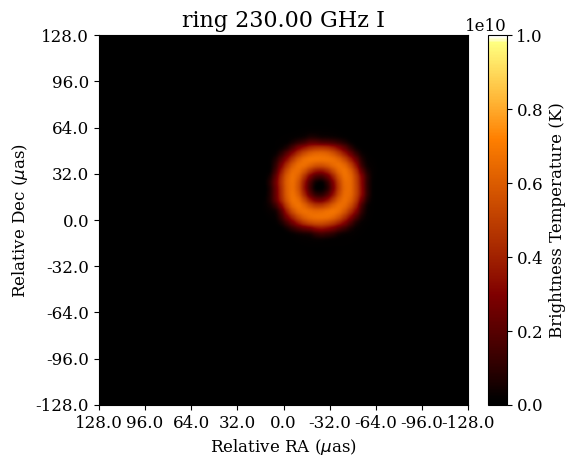

2023-10-18 15:03:29,252 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:03:29,253 INFO Display              :: Penalty--> 180.10823965043772
2023-10-18 15:03:29,483 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:03:29,485 INFO Display              :: Penalty--> 180.10823965043772
2023-10-18 15:03:29,720 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:03:29,722 INFO Display              :: Penalty--> 180.10823965043772
2023-10-18 15:03:29,958 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:03:29,960 INFO Display              :: Penalty--> 180.10823965043772
2023-10-18 15:03:30,193 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:03:30,195 INFO Display              :: Penalty--> 180.10823965043772
2023-10-18 15:03:30,432 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:03:30,433 INFO Display              :: Penalty--> 180.10823965043772
2023-10-18 15:03:30,669 INFO CountIterations      :: iteration = 7 / 2

600.3357602003259
Data Fidelity:  0.8333961303840702


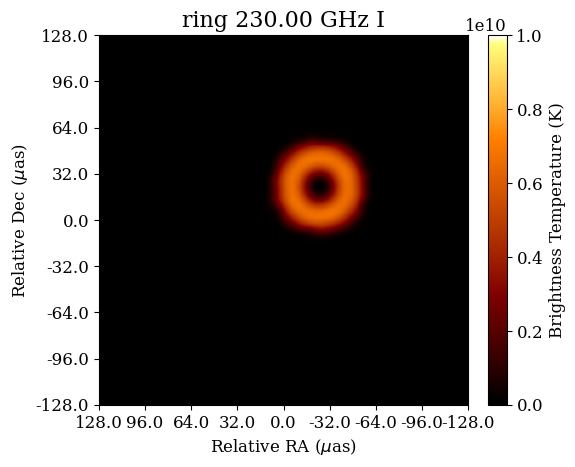

2023-10-18 15:03:35,561 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:03:35,563 INFO Display              :: Penalty--> 179.92437722825977
2023-10-18 15:03:35,801 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:03:35,803 INFO Display              :: Penalty--> 179.92437722825977
2023-10-18 15:03:36,041 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:03:36,043 INFO Display              :: Penalty--> 179.91671626992115
2023-10-18 15:03:36,283 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:03:36,285 INFO Display              :: Penalty--> 179.91671626992115
2023-10-18 15:03:36,525 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:03:36,526 INFO Display              :: Penalty--> 179.91671626992115
2023-10-18 15:03:36,759 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:03:36,761 INFO Display              :: Penalty--> 179.91671626992115
2023-10-18 15:03:37,026 INFO CountIterations      :: iteration = 7 / 2

600.5903481734983
Data Fidelity:  0.8222574685381784


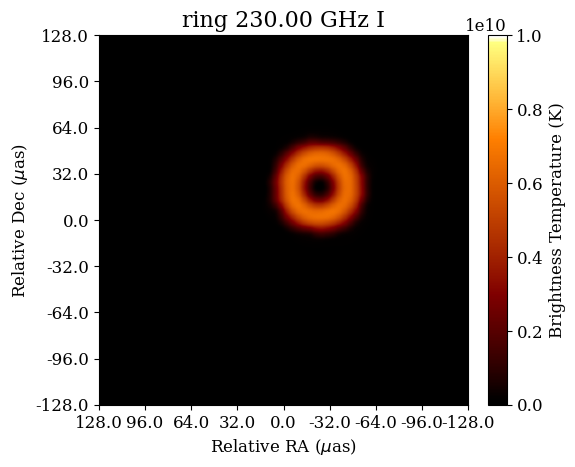

2023-10-18 15:03:42,000 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:03:42,001 INFO Display              :: Penalty--> 179.71140316439505
2023-10-18 15:03:42,256 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:03:42,258 INFO Display              :: Penalty--> 179.71140316439505
2023-10-18 15:03:42,502 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:03:42,503 INFO Display              :: Penalty--> 179.71140316439505
2023-10-18 15:03:42,740 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:03:42,741 INFO Display              :: Penalty--> 179.71140316439505
2023-10-18 15:03:43,019 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:03:43,020 INFO Display              :: Penalty--> 179.71140316439505
2023-10-18 15:03:43,259 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:03:43,261 INFO Display              :: Penalty--> 179.70374220605643
2023-10-18 15:03:43,538 INFO CountIterations      :: iteration = 7 / 2

600.5214863005843
Data Fidelity:  0.8140947597472306


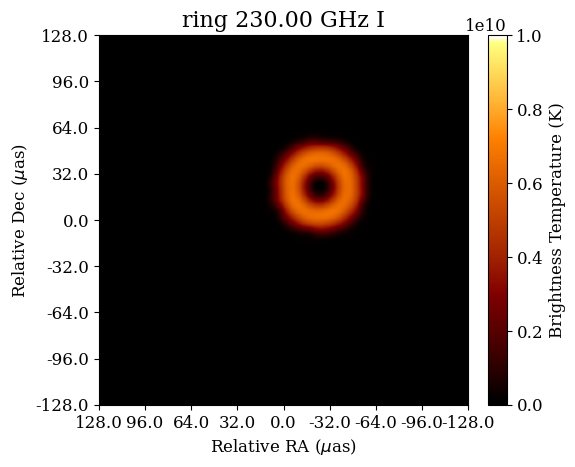

2023-10-18 15:03:49,110 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:03:49,111 INFO Display              :: Penalty--> 179.70106087063792
2023-10-18 15:03:49,346 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:03:49,348 INFO Display              :: Penalty--> 179.70106087063792
2023-10-18 15:03:49,583 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:03:49,584 INFO Display              :: Penalty--> 179.70106087063792
2023-10-18 15:03:49,823 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:03:49,825 INFO Display              :: Penalty--> 179.70106087063792
2023-10-18 15:03:50,110 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:03:50,111 INFO Display              :: Penalty--> 179.70106087063792
2023-10-18 15:03:50,350 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:03:50,351 INFO Display              :: Penalty--> 179.70106087063792
2023-10-18 15:03:50,660 INFO CountIterations      :: iteration = 7 / 2

600.4944810853552
Data Fidelity:  0.8068659700034321


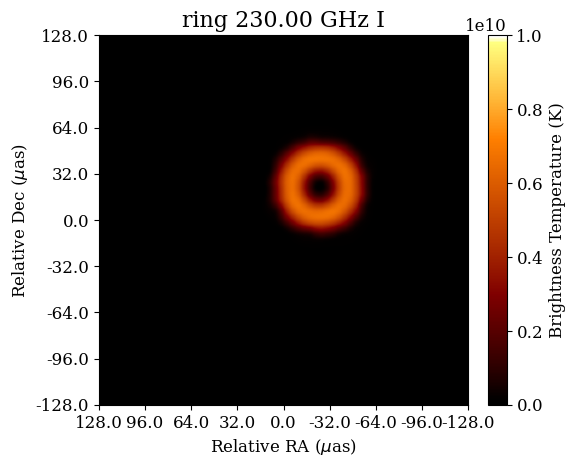

In [15]:
taus = [3, 1]

for i in range(2):
    #blur image to help global convergence
    img = img.blur_circ(psf_fwhm)
    data = handler.convert.ehtim_to_numpy(img)/rescaling
   
    init = np.zeros((len(widths), npix+1, npix+1))
    for j in range(len(widths)):
        init[j] = data
    init = init.flatten()
    
    tau = taus[i]
    
    wtfcts = handler.second_round(init, tau, alpha*noise_levels, maxiter=25, max_iterations=25, display=True)
    
    reco = handler.op(wtfcts)        
    img = handler.wrapper.formatoutput(np.maximum(0, reco))

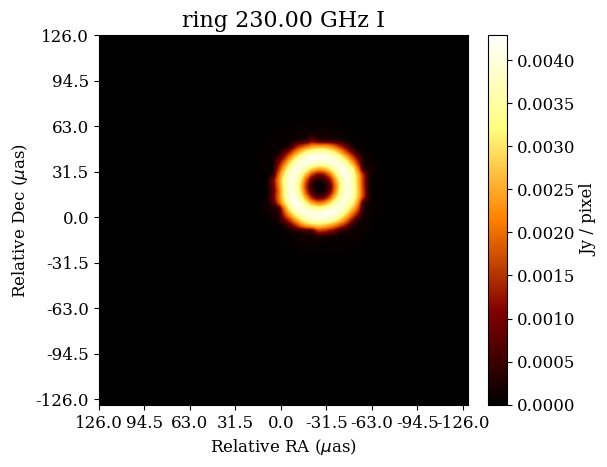

Final data fidelity term:  0.8068659700034321
Final closure phase chi-squared:  0.37004752363034704
Final closure amplitude chi-squared:  0.43681844637308503


In [16]:
img.display()

#print final score
print("Final data fidelity term: ", handler.data_fidelity_closure(wtfcts))
print("Final closure phase chi-squared: ", handler.data_fidelity_cphase(wtfcts))
print("Final closure amplitude chi-squared: ", handler.data_fidelity_logcamp(wtfcts))

Note that although the final data fidelity terms indicate overfitting the final image remains remarkably free from image artifacts due to the powerful regularization. Overfitting can be further reduced by using the discrepancy principle as stopping rule which is fully supported by regpy and imagingbase.